<div class="alert alert-block alert-danger"> run with Python <=3.11.5</div>

In [2]:
import glob
import os
import sys
import tempfile
from pathlib import Path
from zipfile import ZipFile

from dask.diagnostics import ProgressBar
import dask.dataframe as dd
from rapidfuzz import fuzz, process
from tqdm.auto import tqdm

import polars as pl
pl.Config.set_fmt_str_lengths(100)

sys.path.append('..')
from src.read_iris import read_iris


from dask.diagnostics import ProgressBar
ProgressBar().register()

# Read Iris

In [18]:
iris_path = Path('../data/POSTPROCESS-iris-data-2024-06-04.zip')

We read the Master and Identifier tables of the Iris dataset and we join them by the ITEM_ID. We then filter this dataframe to keep only the entries that have at least a non-null DOI, ISBN or PMID. 

We also keep only the OWNING_COLLECTION column to denote the labels of the types of the entries, because of computational efficiency

In [19]:
df_iris_master = pl.read_csv(ZipFile(iris_path).open("ODS_L1_IR_ITEM_MASTER_ALL.csv").read())
df_iris_identifier = pl.read_csv(ZipFile(iris_path).open("ODS_L1_IR_ITEM_IDENTIFIER.csv").read(), columns=['ITEM_ID', 'IDE_DOI', 'IDE_ISBN', 'IDE_PMID'], dtypes={'ITEM_ID': pl.Int64, 'IDE_DOI': pl.Utf8, 'IDE_ISBN': pl.Utf8, 'IDE_PMID': pl.Utf8})
df_iris_relation = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_RELATION.csv').read(), columns=['ITEM_ID', 'REL_ISPARTOFBOOK', 'REL_ISPARTOFJOURNAL'],
                                infer_schema_length=None)
df_iris_description = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_DESCRIPTION.csv').read(), columns=['ITEM_ID', 'DES_ALLPEOPLE', 'DES_NUMBEROFAUTHORS'])
df_iris_publisher = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_PUBLISHER.csv').read(), columns=['ITEM_ID', 'PUB_NAME', 'PUB_PLACE', 'PUB_COUNTRY'])


df = df_iris_identifier.join(df_iris_master, on='ITEM_ID', how='inner').join(df_iris_relation, on='ITEM_ID', how='inner')
#df_authors = df.join(df_iris_description, on='ITEM_ID', how='inner')


df_filtered = df.filter(pl.col('IDE_DOI').is_not_null() | pl.col('IDE_ISBN').is_not_null() | pl.col('IDE_PMID').is_not_null())[
    ['ITEM_ID', 'IDE_DOI', 'IDE_ISBN', 'IDE_PMID', 'OWNING_COLLECTION', 'REL_ISPARTOFBOOK', 'REL_ISPARTOFJOURNAL']
]

df_noid =  df.filter(pl.col('IDE_DOI').is_null() & pl.col('IDE_ISBN').is_null() & pl.col('IDE_PMID').is_null())
print('original len: ', df.__len__(), '| len after filtering: ', df_filtered.__len__())
df_filtered.head()

/tmp/ipykernel_18408/4164397037.py:2: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  df_iris_identifier = pl.read_csv(ZipFile(iris_path).open("ODS_L1_IR_ITEM_IDENTIFIER.csv").read(), columns=['ITEM_ID', 'IDE_DOI', 'IDE_ISBN', 'IDE_PMID'], dtypes={'ITEM_ID': pl.Int64, 'IDE_DOI': pl.Utf8, 'IDE_ISBN': pl.Utf8, 'IDE_PMID': pl.Utf8})


original len:  304952 | len after filtering:  201471


shape: (5, 7)
┌─────────┬───────────────┬───────────────┬──────────┬───────────────┬──────────────┬──────────────┐
│ ITEM_ID ┆ IDE_DOI       ┆ IDE_ISBN      ┆ IDE_PMID ┆ OWNING_COLLEC ┆ REL_ISPARTOF ┆ REL_ISPARTOF │
│ ---     ┆ ---           ┆ ---           ┆ ---      ┆ TION          ┆ BOOK         ┆ JOURNAL      │
│ i64     ┆ str           ┆ str           ┆ str      ┆ ---           ┆ ---          ┆ ---          │
│         ┆               ┆               ┆          ┆ i64           ┆ str          ┆ str          │
╞═════════╪═══════════════╪═══════════════╪══════════╪═══════════════╪══════════════╪══════════════╡
│ 156671  ┆ 10.1688/97838 ┆ 9783866186330 ┆ null     ┆ 41            ┆ New          ┆ null         │
│         ┆ 66187337      ┆ ;             ┆          ┆               ┆ Challenges   ┆              │
│         ┆               ┆ 9783866187337 ┆          ┆               ┆ for a        ┆              │
│         ┆               ┆               ┆          ┆               ┆ Healthy      ┆              │
│         ┆               ┆               ┆          ┆               ┆ Workplace in ┆              │
│         ┆               ┆               ┆          ┆               ┆ Human        ┆              │
│         ┆               ┆               ┆          ┆               ┆ Services     ┆              │
│ 9754    ┆ null          ┆ 9788867414727 ┆ null     ┆ 57            ┆ Fourth Inter ┆ null         │
│         ┆               ┆               ┆          ┆               ┆ national     ┆              │
│         ┆               ┆               ┆          ┆               ┆ Workshop     ┆              │
│         ┆               ┆               ┆          ┆               ┆ EVALITA      ┆              │
│         ┆               ┆               ┆          ┆               ┆ 2014.        ┆              │
│         ┆               ┆               ┆          ┆               ┆ Proceedings  ┆              │
│ 4598    ┆ null          ┆ 9788861328112 ┆ null     ┆ 41            ┆ Commentario  ┆ null         │
│         ┆               ┆               ┆          ┆               ┆ compatto al  ┆              │
│         ┆               ┆               ┆          ┆               ┆ codice       ┆              │
│         ┆               ┆               ┆          ┆               ┆ civile       ┆              │
│ 176800  ┆ null          ┆ 1880094568    ┆ null     ┆ 57            ┆ Proceedings  ┆ null         │
│         ┆               ┆               ┆          ┆               ┆ of ED-MEDIA  ┆              │
│         ┆               ┆               ┆          ┆               ┆ 2005--World  ┆              │
│         ┆               ┆               ┆          ┆               ┆ Conference   ┆              │
│         ┆               ┆               ┆          ┆               ┆ on           ┆              │
│         ┆               ┆               ┆          ┆               ┆ Educational  ┆              │
│         ┆               ┆               ┆          ┆               ┆ Multimedia,  ┆              │
│         ┆               ┆               ┆          ┆               ┆ Hypermedia & ┆              │
│         ┆               ┆               ┆          ┆               ┆ Telecommunic ┆              │
│         ┆               ┆               ┆          ┆               ┆ a…           ┆              │
│ 145288  ┆ null          ┆ 9788823833159 ┆ null     ┆ 50            ┆ null         ┆ null         │
└─────────┴───────────────┴───────────────┴──────────┴───────────────┴──────────────┴──────────────┘

In [20]:
df_iris_master

shape: (304_983, 5)
┌─────────┬──────────────────┬────────────────────────┬───────────────────┬────────────────────────┐
│ ITEM_ID ┆ DATE_ISSUED_YEAR ┆ TITLE                  ┆ OWNING_COLLECTION ┆ OWNING_COLLECTION_DES  │
│ ---     ┆ ---              ┆ ---                    ┆ ---               ┆ ---                    │
│ i64     ┆ i64              ┆ str                    ┆ i64               ┆ str                    │
╞═════════╪══════════════════╪════════════════════════╪═══════════════════╪════════════════════════╡
│ 2766    ┆ 2008             ┆ Bothriocephalidean     ┆ 35                ┆ 1.01 Articolo in       │
│         ┆                  ┆ tapeworms (Cestoda)    ┆                   ┆ rivista                │
│         ┆                  ┆ from the blackfish,    ┆                   ┆                        │
│         ┆                  ┆ Centrolophus niger     ┆                   ┆                        │
│         ┆                  ┆ (Perciformes:          ┆                   ┆                        │
│         ┆                  ┆ Centrolo…              ┆                   ┆                        │
│ 3349    ┆ 2012             ┆ Low-Quality leadership ┆ 35                ┆ 1.01 Articolo in       │
│         ┆                  ┆ in a vertically        ┆                   ┆ rivista                │
│         ┆                  ┆ differentiated duopoly ┆                   ┆                        │
│         ┆                  ┆ with Cournot           ┆                   ┆                        │
│         ┆                  ┆ competition            ┆                   ┆                        │
│ 3867    ┆ 2009             ┆ Due autografi inediti  ┆ 41                ┆ 2.01 Capitolo / saggio │
│         ┆                  ┆ di Luigi Dallapiccola  ┆                   ┆ in libro               │
│ 4342    ┆ 2006             ┆ Il sistema informativo ┆ 49                ┆ 3.01 Monografia /      │
│         ┆                  ┆ contabile. Dalla       ┆                   ┆ trattato scientifico   │
│         ┆                  ┆ pianificazione alla    ┆                   ┆ in forma di libro      │
│         ┆                  ┆ rendicontazione dei    ┆                   ┆                        │
│         ┆                  ┆ risultati              ┆                   ┆                        │
│ 4585    ┆ 2012             ┆ Commento all'art. 1271 ┆ 41                ┆ 2.01 Capitolo / saggio │
│         ┆                  ┆ cod. civ.              ┆                   ┆ in libro               │
│ …       ┆ …                ┆ …                      ┆ …                 ┆ …                      │
│ 724623  ┆ 2023             ┆ Detection of Necrosis  ┆ 35                ┆ 1.01 Articolo in       │
│         ┆                  ┆ in Digitised           ┆                   ┆ rivista                │
│         ┆                  ┆ Whole-Slide Images for ┆                   ┆                        │
│         ┆                  ┆ Better Grading of      ┆                   ┆                        │
│         ┆                  ┆ Canine Soft-Tissue     ┆                   ┆                        │
│         ┆                  ┆ Sarco…                 ┆                   ┆                        │
│ 724249  ┆ 2014             ┆ The Islamic ecumene.   ┆ 41                ┆ 2.01 Capitolo / saggio │
│         ┆                  ┆ Erbil and its region   ┆                   ┆ in libro               │
│         ┆                  ┆ from the conquest of   ┆                   ┆                        │
│         ┆                  ┆ Islam to the present   ┆                   ┆                        │
│ 724571  ┆ 2022             ┆ La Costituzione di     ┆ 35                ┆ 1.01 Articolo in       │
│         ┆                  ┆ Dobbs v. Jackson       ┆                   ┆ rivista                │
│         ┆                  ┆ Women’s Health         ┆                   ┆                        │
│         ┆                  ┆ Organizati

We see that 10 entries do not have a type assigned to them:

Malformed identified are sanitized and discarded if in

In [4]:
df_iris_master.filter(pl.col('OWNING_COLLECTION').is_null())

shape: (10, 5)
┌─────────┬──────────────────┬─────────────────────────┬───────────────────┬───────────────────────┐
│ ITEM_ID ┆ DATE_ISSUED_YEAR ┆ TITLE                   ┆ OWNING_COLLECTION ┆ OWNING_COLLECTION_DES │
│ ---     ┆ ---              ┆ ---                     ┆ ---               ┆ ---                   │
│ i64     ┆ i64              ┆ str                     ┆ i64               ┆ str                   │
╞═════════╪══════════════════╪═════════════════════════╪═══════════════════╪═══════════════════════╡
│ 752849  ┆ 2023             ┆ Being Reassuring About  ┆ null              ┆ null                  │
│         ┆                  ┆ the Past While          ┆                   ┆                       │
│         ┆                  ┆ Promising a Better      ┆                   ┆                       │
│         ┆                  ┆ Future: How Companies   ┆                   ┆                       │
│         ┆                  ┆ Frame Temporal Focus …  ┆                   ┆                       │
│ 764664  ┆ 2023             ┆ The Impact of           ┆ null              ┆ null                  │
│         ┆                  ┆ Place-based Policies on ┆                   ┆                       │
│         ┆                  ┆ Interpersonal Income    ┆                   ┆                       │
│         ┆                  ┆ Inequality              ┆                   ┆                       │
│ 770185  ┆ 2023             ┆ Mutamenti degli spazi   ┆ null              ┆ null                  │
│         ┆                  ┆ urbani e presenza       ┆                   ┆                       │
│         ┆                  ┆ straniera nella Torino  ┆                   ┆                       │
│         ┆                  ┆ post-industriale        ┆                   ┆                       │
│ 779533  ┆ 2023             ┆ From France to Florence ┆ null              ┆ null                  │
│         ┆                  ┆ : Marriage Strategies,  ┆                   ┆                       │
│         ┆                  ┆ Political Education and ┆                   ┆                       │
│         ┆                  ┆ Raison d’État in the    ┆                   ┆                       │
│         ┆                  ┆ Case of …               ┆                   ┆                       │
│ 779773  ┆ 2023             ┆ Planetary gardening via ┆ null              ┆ null                  │
│         ┆                  ┆ female-led anthologies  ┆                   ┆                       │
│         ┆                  ┆ of women’s poetry in    ┆                   ┆                       │
│         ┆                  ┆ French                  ┆                   ┆                       │
│ 796202  ┆ 2024             ┆ Mobile applications     ┆ null              ┆ null                  │
│         ┆                  ┆ (apps) as service       ┆                   ┆                       │
│         ┆                  ┆ provider actors         ┆                   ┆                       │
│ 670424  ┆ 2022             ┆ Asteroseismology of β   ┆ null              ┆ null                  │
│         ┆                  ┆ Cephei stars: The       ┆                   ┆                       │
│         ┆                  ┆ stellar inferences      ┆                   ┆                       │
│         ┆                  ┆ tested in hare and      ┆                   ┆                       │
│         ┆                  ┆ hound exercises         ┆                   ┆                       │
│ 687115  ┆ 2022             ┆ Simulations of black    ┆ null              ┆ null                  │
│         ┆                  ┆ hole fueling in         ┆                   ┆                       │
│         ┆                  ┆ isolated and merging    ┆                   ┆                       │
│         ┆                  ┆ galaxies with an        ┆                   ┆                       │
│         ┆                  ┆ explicit, multi

We create a dictionary that maps the types' labels to their descriptions: 

In [21]:
type_df = df_iris_master[['OWNING_COLLECTION', 'OWNING_COLLECTION_DES']].drop_nulls('OWNING_COLLECTION').unique('OWNING_COLLECTION')
type_dict = dict(type_df.sort(pl.col('OWNING_COLLECTION')).iter_rows())
type_dict

{35: '1.01 Articolo in rivista',
 36: '1.02 Nota a sentenza',
 37: '1.03 Recensione in rivista',
 38: '1.04 Replica / breve intervento (e simili)',
 39: '1.05 Scheda bibliografica',
 40: '1.06 Abstract in rivista',
 41: '2.01 Capitolo / saggio in libro',
 42: '2.02 Prefazione',
 43: '2.03 Postfazione',
 44: '2.04 Breve introduzione',
 45: '2.05 Voce in dizionario o enciclopedia',
 46: '2.06 Commento giuridico',
 47: '2.07 Scheda di catalogo',
 48: '2.08 Recensione in volume',
 49: '3.01 Monografia / trattato scientifico in forma di libro',
 50: '3.02 Curatela',
 51: '3.03 Edizione critica',
 52: '3.04 Pubblicazione di fonti inedite',
 53: '3.05 Concordanze',
 54: '3.06 Indice',
 55: '3.07 Bibliografia',
 56: '3.08 Edizione annotata/scolastica',
 57: '4.01 Contributo in Atti di convegno',
 58: '4.02 Riassunto (Abstract)',
 59: '4.03 Poster',
 60: '5.01 Libro (Traduzione)',
 61: '5.02 Contributo in volume (Traduzione)',
 62: '5.03 Contributo in rivista (Traduzione)',
 63: '5.04 Traduzion

In [6]:
# count of the types in the unfiltered IRIS:
df_iris_master['OWNING_COLLECTION'].value_counts(sort=True)

shape: (50, 2)
┌───────────────────┬────────┐
│ OWNING_COLLECTION ┆ count  │
│ ---               ┆ ---    │
│ i64               ┆ u32    │
╞═══════════════════╪════════╡
│ 35                ┆ 149825 │
│ 41                ┆ 45235  │
│ 57                ┆ 36106  │
│ 58                ┆ 18655  │
│ 49                ┆ 7994   │
│ …                 ┆ …      │
│ null              ┆ 10     │
│ 72                ┆ 8      │
│ 53                ┆ 6      │
│ 75                ┆ 6      │
│ 70                ┆ 3      │
└───────────────────┴────────┘

## Crossref API [skip]

In [7]:
noid_df =  df.filter(pl.col('IDE_DOI').is_null() & pl.col('IDE_ISBN').is_null() & pl.col('IDE_PMID').is_null())
df_iris_description = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_DESCRIPTION.csv').read(), columns=['ITEM_ID', 'DES_ALLPEOPLE', 'DES_NUMBEROFAUTHORS'])
df_iris_publisher = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_PUBLISHER.csv').read(), columns=['ITEM_ID', 'PUB_NAME', 'PUB_PLACE', 'PUB_COUNTRY'])
df_iris_language = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_LANGUAGE.csv').read(), columns=['ITEM_ID', 'LAN_ISO'])

noid_df = noid_df.join(df_iris_description, on='ITEM_ID', how='left')
noid_df = noid_df.join(df_iris_publisher, on='ITEM_ID', how='left')
noid_df = noid_df.join(df_iris_language, on='ITEM_ID', how='left')


noid_df.head(5)

shape: (5, 16)
┌─────────┬─────────┬──────────┬──────────┬───┬────────────────┬───────────┬─────────────┬─────────┐
│ ITEM_ID ┆ IDE_DOI ┆ IDE_ISBN ┆ IDE_PMID ┆ … ┆ PUB_NAME       ┆ PUB_PLACE ┆ PUB_COUNTRY ┆ LAN_ISO │
│ ---     ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---            ┆ ---       ┆ ---         ┆ ---     │
│ i64     ┆ str     ┆ str      ┆ str      ┆   ┆ str            ┆ str       ┆ str         ┆ str     │
╞═════════╪═════════╪══════════╪══════════╪═══╪════════════════╪═══════════╪═════════════╪═════════╡
│ 131507  ┆ null    ┆ null     ┆ null     ┆ … ┆ Sun SITE       ┆ AACHEN    ┆ DEU         ┆ eng     │
│         ┆         ┆          ┆          ┆   ┆ Central        ┆           ┆             ┆         │
│         ┆         ┆          ┆          ┆   ┆ Europe, RWTH   ┆           ┆             ┆         │
│         ┆         ┆          ┆          ┆   ┆ Aachen         ┆           ┆             ┆         │
│         ┆         ┆          ┆          ┆   ┆ University     ┆           ┆             ┆         │
│ 9079    ┆ null    ┆ null     ┆ null     ┆ … ┆ null           ┆ null      ┆ null        ┆ null    │
│ 219737  ┆ null    ┆ null     ┆ null     ┆ … ┆ null           ┆ null      ┆ null        ┆ por     │
│ 148465  ┆ null    ┆ null     ┆ null     ┆ … ┆ null           ┆ null      ┆ null        ┆ null    │
│ 146224  ┆ null    ┆ null     ┆ null     ┆ … ┆ null           ┆ null      ┆ null        ┆ eng     │
└─────────┴─────────┴──────────┴──────────┴───┴────────────────┴───────────┴─────────────┴─────────┘

In [203]:
print(noid_df.__len__())
noid_df = noid_df.filter(pl.col('OWNING_COLLECTION').is_in([35, 45, 49, 57, 58, 68])) #scelta fatta sulla base dei risultati dei primi 250 elementi
print(noid_df.__len__())
records = noid_df.select(['ITEM_ID', 'DES_ALLPEOPLE', 'PUB_NAME', 'DATE_ISSUED_YEAR', 'TITLE', 'OWNING_COLLECTION']).to_dicts()

records

103481
69884


[{'ITEM_ID': 131507,
  'DES_ALLPEOPLE': 'Sara Montagna; Andrea Omicini; Alessandro Ricci',
  'PUB_NAME': 'Sun SITE Central Europe, RWTH Aachen University',
  'DATE_ISSUED_YEAR': 2010,
  'TITLE': 'A Multiscale Agent-based Model of Morphogenesis in Biological Systems',
  'OWNING_COLLECTION': 57},
 {'ITEM_ID': 219737,
  'DES_ALLPEOPLE': 'Bacchini, Luca',
  'PUB_NAME': None,
  'DATE_ISSUED_YEAR': 2014,
  'TITLE': 'Re-revisão de Sousândrade. Poesia e escuta de Nova Iorque',
  'OWNING_COLLECTION': 35},
 {'ITEM_ID': 148465,
  'DES_ALLPEOPLE': 'A.Galvani; M.G.Angeli; F. Pontoni; F.Marabini; P.Gasparetto; A.Mertzanis',
  'PUB_NAME': None,
  'DATE_ISSUED_YEAR': 2011,
  'TITLE': 'The environmental vulnerability of the coastal zone and the importance of the cartography',
  'OWNING_COLLECTION': 68},
 {'ITEM_ID': 146224,
  'DES_ALLPEOPLE': 'G. Baldazzi; S. Faenza; G. Testoni; P.L. Rossi; T. Bernardi',
  'PUB_NAME': None,
  'DATE_ISSUED_YEAR': 2004,
  'TITLE': 'Measurements of Electro-Magnetic Fields

In [204]:
import requests
from pprint import pprint
from rapidfuzz import fuzz

results = {}


api_url = "https://api.crossref.org/works"
headers = {
    "User-Agent": "YourAppName/1.0 (https://example.org/YourAppName/; mailto:leonardo.zilli@studio.unibo.it)"
}

for record in tqdm(records, position=0, leave=True):
    title = record.get('TITLE')
    author = record.get('DES_ALLPEOPLE')
    year = record.get('DATE_ISSUED_YEAR')
    item_id = record.get('ITEM_ID')
    type = record.get('OWNING_COLLECTION')

    # Form the query parameters
    params = {
        "query.title": title,
        "query.author": author,
        "filter": f"from-pub-date:{year},until-pub-date:{year}"
    }

    # Make the API call
    response = requests.get(api_url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        for item in data['message']['items'][:10]:
            item_title = item.get('title')[0]
            similarity_score = fuzz.ratio(title, item_title)
            if similarity_score >= 80:
                print(f"{type} - {similarity_score} - {item['URL']}, {item_title}")
                #add to dict
                results[item_id] = item['URL']
                break

    else:
        print(f"Failed to fetch data for {title} by {author} in {year}: {response.status_code}")
    
    print()


  0%|          | 0/69884 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
len(results)

66

In [ ]:
rs_df = pl.DataFrame(list(results.items()), schema=['ITEM_ID', 'URL'])
rs_df = rs_df.join(noid_df, on='ITEM_ID', how='inner')

rs_df['OWNING_COLLECTION'].unique().to_list()

[35, 45, 49, 57, 58, 68]

# Get ID list

We extract a list of all the external IDs for each entry of the filtered IRIS dataframe by extracting the values of the columns `IDE_DOI`, `IDE_ISBN`, and `IDE_PMID`. These ids are normalized and the rotten ones are filtered out. Finally, they are all stored in a single list that we'll use to filter the Meta dump.

In [8]:
dois = df_filtered.select('ITEM_ID', 'IDE_DOI', 'OWNING_COLLECTION').drop_nulls('IDE_DOI')

filtered_dois = (
    dois
    .with_columns(('doi:'+pl.col('IDE_DOI').str.extract(r'(10\.\d{4,}\/[^,\s;]*)').str.to_lowercase()).alias('id'))
    .drop_nulls('id')
    .drop('IDE_DOI')
    .rename({'ITEM_ID': 'iris_id'})
)

pmids = df_filtered.select('ITEM_ID', 'IDE_PMID', 'OWNING_COLLECTION').drop_nulls('IDE_PMID')

filtered_pmids = (
    pmids
    .filter(
        ~pl.col('IDE_PMID').str.contains('PMC')
        )
    .with_columns(('pmid:'+pl.col('IDE_PMID').str.extract(r'0*([1-9][0-9]{1,8})', 1).str.to_lowercase()).alias('id'))
    .drop('IDE_PMID')
    .rename({'ITEM_ID': 'iris_id'})
)

isbns = df_filtered.select('ITEM_ID', 'IDE_ISBN', 'OWNING_COLLECTION').drop_nulls('IDE_ISBN')

filtered_isbns = (
    isbns
    .with_columns(
        ('isbn:'+pl.col('IDE_ISBN').str.extract_all(r'(ISBN[-]*(1[03])*[ ]*(: ){0,1})*(([0-9Xx][- ]*){13}|([0-9Xx][- ]*){10})').list.first().str.replace_all(r'[- ]', '').str.to_lowercase()).alias('id')
    )
    .drop_nulls('id')
    .drop('IDE_ISBN')
    .rename({'ITEM_ID': 'iris_id'})
)


dois_pmids_isbns_list = pl.concat([filtered_dois, filtered_pmids, filtered_isbns]).rename({'OWNING_COLLECTION': 'iris_type'})

print('number of ids:', len(dois_pmids_isbns_list))
dois_pmids_isbns_list.head()

number of ids: 257471


shape: (5, 3)
┌─────────┬───────────┬──────────────────────────────────┐
│ iris_id ┆ iris_type ┆ id                               │
│ ---     ┆ ---       ┆ ---                              │
│ i64     ┆ i64       ┆ str                              │
╞═════════╪═══════════╪══════════════════════════════════╡
│ 156671  ┆ 41        ┆ doi:10.1688/9783866187337        │
│ 148354  ┆ 35        ┆ doi:10.1007/s00180-012-0319-z    │
│ 146851  ┆ 35        ┆ doi:10.1002/cmdc.201100471       │
│ 147819  ┆ 35        ┆ doi:10.1097/gme.0b013e318240fe3d │
│ 148141  ┆ 57        ┆ doi:10.1109/aero.2012.6187311    │
└─────────┴───────────┴──────────────────────────────────┘

However, we have lots of duplicates in the list, both from the iris dataset (iris entries that had multiple external ids) and from the external ids (multiple iris entries that share the same external id).

Let's deal with the former case first:

In [9]:
dois_pmids_isbns_list

shape: (257_471, 3)
┌─────────┬───────────┬──────────────────────────────────┐
│ iris_id ┆ iris_type ┆ id                               │
│ ---     ┆ ---       ┆ ---                              │
│ i64     ┆ i64       ┆ str                              │
╞═════════╪═══════════╪══════════════════════════════════╡
│ 156671  ┆ 41        ┆ doi:10.1688/9783866187337        │
│ 148354  ┆ 35        ┆ doi:10.1007/s00180-012-0319-z    │
│ 146851  ┆ 35        ┆ doi:10.1002/cmdc.201100471       │
│ 147819  ┆ 35        ┆ doi:10.1097/gme.0b013e318240fe3d │
│ 148141  ┆ 57        ┆ doi:10.1109/aero.2012.6187311    │
│ …       ┆ …         ┆ …                                │
│ 708664  ┆ 41        ┆ isbn:9788822910172               │
│ 709736  ┆ 57        ┆ isbn:9791221025378               │
│ 710572  ┆ 57        ┆ isbn:9788887744965               │
│ 693533  ┆ 41        ┆ isbn:9788892801394               │
│ 693581  ┆ 41        ┆ isbn:9788800862875               │
└─────────┴───────────┴──────────────────────────────────┘

In [11]:
dpi_dupes_iris = dois_pmids_isbns_list.filter(pl.col("iris_id").is_duplicated()).sort("iris_id").with_columns(pl.col('iris_type').replace_strict(type_dict))
dpi_dupes_iris_grouped = (dpi_dupes_iris.group_by('iris_id').len().sort('len'))
print('We found', dpi_dupes_iris_grouped.select(pl.len()).item(), 'iris entries that are tied to more than one external identifier')
dpi_dupes_iris_grouped.select(pl.col('len').value_counts()).unnest('len').rename({'len': '# of dupes', 'count': '# of ids'})

We found 56682 iris entries that are tied to more than one external identifier


shape: (2, 2)
┌────────────┬──────────┐
│ # of dupes ┆ # of ids │
│ ---        ┆ ---      │
│ u32        ┆ u32      │
╞════════════╪══════════╡
│ 2          ┆ 56529    │
│ 3          ┆ 153      │
└────────────┴──────────┘

In [13]:
dpi_dupes_iris.head(10)

shape: (10, 3)
┌─────────┬─────────────────────────────────┬───────────────────────────────────┐
│ iris_id ┆ iris_type                       ┆ id                                │
│ ---     ┆ ---                             ┆ ---                               │
│ i64     ┆ str                             ┆ str                               │
╞═════════╪═════════════════════════════════╪═══════════════════════════════════╡
│ 360     ┆ 2.01 Capitolo / saggio in libro ┆ doi:10.1007/0-387-30394-4_33      │
│ 360     ┆ 2.01 Capitolo / saggio in libro ┆ isbn:0387298118                   │
│ 718     ┆ 1.01 Articolo in rivista        ┆ doi:10.1016/j.ejheart.2006.01.012 │
│ 718     ┆ 1.01 Articolo in rivista        ┆ pmid:16540371                     │
│ 1016    ┆ 1.01 Articolo in rivista        ┆ doi:10.1017/s0265021506000962     │
│ 1016    ┆ 1.01 Articolo in rivista        ┆ pmid:16824239                     │
│ 1018    ┆ 1.01 Articolo in rivista        ┆ doi:10.1016/j.camlet.2005.02.019  │
│ 1018    ┆ 1.01 Articolo in rivista        ┆ pmid:16458119                     │
│ 1019    ┆ 1.01 Articolo in rivista        ┆ doi:10.1016/j.bbrc.2005.05.119    │
│ 1019    ┆ 1.01 Articolo in rivista        ┆ pmid:15950945                     │
└─────────┴─────────────────────────────────┴───────────────────────────────────┘

In [14]:
# the elements that share the same iris ID all have the same type
same_type = dpi_dupes_iris.group_by("iris_id").agg([
    pl.col("iris_type").n_unique().alias("unique_count")
])
different_types = same_type.filter(pl.col("unique_count") != 1)
different_types

shape: (0, 2)
┌─────────┬──────────────┐
│ iris_id ┆ unique_count │
│ ---     ┆ ---          │
│ i64     ┆ u32          │
╞═════════╪══════════════╡
└─────────┴──────────────┘

We keep only the first occurrence of each external id in the list. Given how the list has been constructed, this creates a hierarchical order of preference for the external ids: DOI > PMID > ISBN.

In [17]:
print('num. of ids:', dois_pmids_isbns_list.__len__())
dois_pmids_isbns_filtered = dois_pmids_isbns_list.unique('iris_id', keep='first', maintain_order=True)
print('num. of ids after unique id filtering:', dois_pmids_isbns_filtered.__len__())

num. of ids: 257471
num. of ids after unique id filtering: 200636


Let's now deal with the duplicates from the external ids:

In [18]:
dpi_dupes_id = dois_pmids_isbns_filtered.filter(pl.col("id").is_duplicated()).sort("id").with_columns(pl.col('iris_type'))#.replace(type_dict))
dpi_dupes_id_grouped = (dpi_dupes_id.group_by('id').len().sort('len'))
print('We found', dpi_dupes_id.select(pl.col('iris_id').unique().len()).item(), 'external ids that are tied to more than one iris entry')
print()
print('The external identifiers appear with the following distribution:')
dpi_dupes_id_grouped.select(pl.col('len').value_counts()).unnest('len').rename({'len': '# of dupes', 'count': '# of ext. ids'})

We found 42720 external ids that are tied to more than one iris entry

The external identifiers appear with the following distribution:


shape: (50, 2)
┌────────────┬───────────────┐
│ # of dupes ┆ # of ext. ids │
│ ---        ┆ ---           │
│ u32        ┆ u32           │
╞════════════╪═══════════════╡
│ 2          ┆ 6037          │
│ 3          ┆ 2288          │
│ 4          ┆ 1160          │
│ 5          ┆ 709           │
│ 6          ┆ 463           │
│ …          ┆ …             │
│ 69         ┆ 1             │
│ 71         ┆ 1             │
│ 74         ┆ 1             │
│ 151        ┆ 1             │
│ 275        ┆ 1             │
└────────────┴───────────────┘

As you can see from the table above, the majority of the external id duplicates are pairs, but we have cases in which the same external id is shared by up to 275 iris entries!! 

The vast majority of the duplicates seem to be coming from the ISBNs:

In [19]:
dpi_dupes_id_grouped = dpi_dupes_id_grouped.with_columns(pl.col('id').str.extract(r'^(doi|pmid|isbn)').alias('id_type'))
dpi_dupes_id_grouped.select(pl.col('id_type').value_counts()).unnest('id_type').rename({'id_type': 'id type', 'count': '# of ext. ids'})

shape: (3, 2)
┌─────────┬───────────────┐
│ id type ┆ # of ext. ids │
│ ---     ┆ ---           │
│ str     ┆ u32           │
╞═════════╪═══════════════╡
│ pmid    ┆ 6             │
│ doi     ┆ 832           │
│ isbn    ┆ 10933         │
└─────────┴───────────────┘

We deal with deduplicating the three different types of id in three different ways:

##### DOI deduplication

In [34]:
doi_dupes_df = dpi_dupes_id.filter(pl.col('id').str.starts_with('doi:'))
print(doi_dupes_df.__len__())

#doi_search = df.join(doi_dupes_df, left_on='ITEM_ID', right_on='iris_id').join(df_iris_description, on='ITEM_ID', how='inner').join(df_iris_relation, on='ITEM_ID', how='inner').join(df_iris_publisher, on='ITEM_ID', how='inner')

1851


For what concernes duplicates with the same type, we keep only the first one encountered.

In [35]:
keep_doi = doi_dupes_df.unique(['iris_type', 'id'], keep='first', maintain_order=True)
print(keep_doi.filter(pl.col('id').is_duplicated()).__len__(), 'duplicates remanining;', keep_doi.filter(pl.col('id').is_duplicated()).n_unique('id'), 'unique ids')

291 duplicates remanining; 140 unique ids


This leaves 140 duplicate elements (291 entities) with different types. Among each of these we try to pick what we consider the 'container' element by sorting each group of duplicates based on a priority mapping of the types of the elements as described in the IRIS dataset and finally picking the first one. 

We don't need to specify a priority for each and every type present in the dataset, as per our observations the most common source of problems are the ones tied to a restricted set of types.
These problems are also often not coherent among the dataset, so finding a container for each of them is not really feasible. In the harder cases we just keep the first one encountered.

In [36]:
def doi_heuristic(group):
    priority = {
        35: 1, 50: 2, 41: 3, 57: 4
    }

    sorted_iris_types = group.sort(pl.col("iris_type").replace(priority, default=float('inf')))
    return sorted_iris_types.head(1)

keep_doi = keep_doi.group_by("id").map_groups(doi_heuristic)
print('number of doi duplicates: ', keep_doi.filter(pl.col('id').is_duplicated()).__len__())

/tmp/ipykernel_2724882/2901204041.py:6: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  sorted_iris_types = group.sort(pl.col("iris_type").replace(priority, default=float('inf')))


number of doi duplicates:  0


In [37]:
doi_dupes_list = doi_dupes_df.select('iris_id')
drop_doi = doi_dupes_list.join(keep_doi, on='iris_id', how='anti')

Finally, we remove the dupicates DOIs from the original list of external ids.

In [38]:
dois_pmids_isbns_filtered = dois_pmids_isbns_filtered.join(drop_doi, on='iris_id', how='anti')
dois_pmids_isbns_filtered.__len__()

199617

#### Dedupicate PMID

The dupicate PMID are only 6:

In [39]:
pmid_dupes_list = dpi_dupes_id.filter(pl.col('id').str.starts_with('pmid:')).select('iris_id')

pmid_search = df.filter(pl.col('ITEM_ID').is_in(pmid_dupes_list)).join(df_iris_description, on='ITEM_ID', how='inner').join(df_iris_relation, on='ITEM_ID', how='inner').join(df_iris_publisher, on='ITEM_ID', how='inner')

pmid_search.group_by('IDE_PMID').agg(pl.len()).sort('IDE_PMID')

shape: (7, 2)
┌───────────────┬─────┐
│ IDE_PMID      ┆ len │
│ ---           ┆ --- │
│ str           ┆ u32 │
╞═══════════════╪═════╡
│ 17465331      ┆ 2   │
│ 19112936      ┆ 2   │
│ 24293487      ┆ 2   │
│ 25824864      ┆ 2   │
│ 28488176      ┆ 3   │
│ 9276009       ┆ 1   │
│ PMID: 9276009 ┆ 1   │
└───────────────┴─────┘

We exclude the duplicate 'Abstracts' and keep only the first occurrence of each 'Article'.

In [40]:
keep_pmid = dpi_dupes_id.filter(pl.col('id').str.starts_with('pmid:')).filter(pl.col('iris_type') != 40).unique('id', keep='first', maintain_order=True)
drop_pmid = pmid_dupes_list.join(keep_pmid, on='iris_id', how='anti')

In [41]:
dois_pmids_isbns_filtered = dois_pmids_isbns_filtered.join(drop_pmid, on='iris_id', how='anti')
dois_pmids_isbns_filtered.__len__()

199608

#### Deduplicate ISBN

In [42]:
isbn_dupes_df = dpi_dupes_id.filter(pl.col('id').str.starts_with('isbn:'))
print(isbn_dupes_df.__len__(), '| unique isbns: ', isbn_dupes_df.unique('id').__len__())

#isbn_search = df.join(doi_dupes_df, left_on='ITEM_ID', right_on='iris_id').join(df_iris_description, on='ITEM_ID', how='inner').join(df_iris_relation, on='ITEM_ID', how='inner').join(df_iris_publisher, on='ITEM_ID', how='inner')

#doi_search.sort('id').head(6)

40856 | unique isbns:  10933


We keep only the first occurrence of the entries with the same external id and type:

In [43]:
keep_isbn = isbn_dupes_df.unique(['iris_type', 'id'], keep='first', maintain_order=True)
print('the number of elements came down to', keep_isbn.__len__(), 'but there are still', keep_isbn.filter(pl.col('id').is_duplicated()).__len__(), 'duplicates')

the number of elements came down to 18286 but there are still 13158 duplicates


And then we pick the entries that have the same external id but different types based on a priority list. (note that, if not specified in the priority list, the heuristic will only keep the top-most entry like it has found it in the df.)

In [44]:
type_dict[41]

'2.01 Capitolo / saggio in libro'

In [45]:
pl.Config.set_tbl_rows(100)
keep_isbn.group_by("id").agg(
    pl.all()
).filter(~pl.col('iris_type').list.contains(49) | ~pl.col('iris_type').list.contains(35))

shape: (10_933, 3)
┌────────────────────┬──────────────────────────┬──────────────┐
│ id                 ┆ iris_id                  ┆ iris_type    │
│ ---                ┆ ---                      ┆ ---          │
│ str                ┆ list[i64]                ┆ list[i64]    │
╞════════════════════╪══════════════════════════╪══════════════╡
│ isbn:9788881074679 ┆ [754106, 699988]         ┆ [41, 49]     │
│ isbn:9788890909207 ┆ [174913, 174635, 183950] ┆ [58, 59, 57] │
│ isbn:9783981537062 ┆ [322248]                 ┆ [57]         │
│ isbn:1579583997    ┆ [56671]                  ┆ [45]         │
│ isbn:9780853583196 ┆ [367642]                 ┆ [57]         │
│ isbn:9788812000401 ┆ [136952]                 ┆ [45]         │
│ isbn:9788813272159 ┆ [152813]                 ┆ [41]         │
│ isbn:9788843045501 ┆ [105422, 102784]         ┆ [41, 50]     │
│ isbn:9788854970335 ┆ [553078]                 ┆ [41]         │
│ isbn:9788878475885 ┆ [553942]                 ┆ [41]         │
│ isbn:9788890992209 ┆ [180727, 180687, 180722] ┆ [41, 50, 42] │
│ isbn:9783030495169 ┆ [578358, 583907]         ┆ [50, 41]     │
│ isbn:9788891931191 ┆ [677582, 697565]         ┆ [41, 49]     │
│ isbn:9786086508210 ┆ [142586, 166178]         ┆ [50, 41]     │
│ isbn:9788800745994 ┆ [193829, 193826]         ┆ [41, 50]     │
│ isbn:9788896386156 ┆ [180335, 145192]         ┆ [41, 49]     │
│ isbn:9788897385745 ┆ [207946]                 ┆ [41]         │
│ isbn:9781412959636 ┆ [186712]                 ┆ [45]         │
│ isbn:9788806207441 ┆ [143671]                 ┆ [41]         │
│ isbn:9788898003075 ┆ [183548, 186566]         ┆ [50, 61]     │
│ isbn:9788869233814 ┆ [416303, 416305]         ┆ [41, 50]     │
│ isbn:9788891613721 ┆ [232977]                 ┆ [41]         │
│ isbn:9789463665742 ┆ [741235, 716491]         ┆ [41, 57]     │
│ isbn:9789525576085 ┆ [120372]                 ┆ [41]         │
│ isbn:9788856805345 ┆ [110882, 110851]         ┆ [41, 50]     │
│ isbn:9788894138719 ┆ [275652]                 ┆ [41]         │
│ isbn:9788362891054 ┆ [166430, 747016]         ┆ [58, 57]     │
│ isbn:9788869721229 ┆ [371276, 371278, 371273] ┆ [42, 41, 50] │
│ isbn:9788828846338 ┆ [754617, 759269]         ┆ [41, 46]     │
│ isbn:888988407x    ┆ [93398]                  ┆ [57]         │
│ isbn:9788879755245 ┆ [141455]                 ┆ [41]         │
│ isbn:9788889287101 ┆ [157288, 619861]         ┆ [41, 57]     │
│ isbn:9789543238323 ┆ [140574]                 ┆ [41]         │
│ isbn:9789608475120 ┆ [111491]                 ┆ [57]         │
│ isbn:9781138029262 ┆ [212019]                 ┆ [41]         │
│ isbn:9788877651532 ┆ [764933, 764938, 764861] ┆ [42, 41, 50] │
│ isbn:9783034313315 ┆ [205025, 205046]         ┆ [41, 50]     │
│ isbn:8814180385    ┆ [143155]                 ┆ [41]         │
│ isbn:9788855530248 ┆ [119576, 119893]         ┆ [41, 50]     │
│ isbn:9783830069713 ┆ [156405]                 ┆ [41]         │
│ isbn:9788879706414 ┆ [189241]                 ┆ [57]         │
│ isbn:9789004150270 ┆ [154520]                 ┆ [35]         │
│ isbn:9789004299375 ┆ [422673, 681362]         ┆ [45, 41]     │
│ isbn:9791035108977 ┆ [769852]                 ┆ [41]         │
│ isbn:9788873813880 ┆ [139332, 139342]         ┆ [49, 41]     │
│ isbn:9780203095430 ┆ [148015, 148008, 148014] ┆ [50, 41, 44] │
│ isbn:9788813369439 ┆ [422862, 673710]         ┆ [46, 41]     │
│ isbn:9781567003031 ┆ [155001]                 ┆ [57]         │
│ isbn:9783319043814 ┆ [182463, 180945]         ┆ [41, 50]     │
│ isbn:9788832028027 ┆ [521943, 722594]         ┆ [41, 57]     │
│ …                  ┆ …                        ┆ …            │
│ isbn:9788891604200 ┆ [407289]                 ┆ [41]         │
│ isbn:9788891789907 ┆ [441986, 441988]         ┆ [41, 50]     │
│ isbn:8846457862    ┆ [52928]                  ┆ [41]         │
│ isbn:9788883381447 ┆ [185646, 180508]         ┆ [57, 58]     │
│ isbn:9783540207832 ┆ [65589, 55100]           ┆ [41, 49]     │
│ isbn:887988051

In [47]:
def isbn_heuristic(group):
    priority = {
        49: 1, 35: 2
    }

    sorted_iris_types = group.sort(pl.col("iris_type").replace(priority, default=float('inf')))
    return sorted_iris_types.head(1)

keep_isbn = keep_isbn.group_by("id").map_groups(isbn_heuristic)
keep_isbn.__len__(), keep_isbn.filter(pl.col('id').is_duplicated()).__len__()

/tmp/ipykernel_2724882/690631519.py:6: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  sorted_iris_types = group.sort(pl.col("iris_type").replace(priority, default=float('inf')))


(10933, 0)

In [48]:
type_dict[41]

'2.01 Capitolo / saggio in libro'

In [49]:
keep_isbn.filter(pl.col('id') == 'isbn:9788849134728')

shape: (1, 3)
┌─────────┬───────────┬────────────────────┐
│ iris_id ┆ iris_type ┆ id                 │
│ ---     ┆ ---       ┆ ---                │
│ i64     ┆ i64       ┆ str                │
╞═════════╪═══════════╪════════════════════╡
│ 136116  ┆ 50        ┆ isbn:9788849134728 │
└─────────┴───────────┴────────────────────┘

<div class='alert alert-warning'>Results to be checked</div>

In [50]:
isbn_dupes_list = isbn_dupes_df.select('iris_id')
drop_isbn = isbn_dupes_list.join(keep_isbn, on='iris_id', how='anti')

In [51]:
dois_pmids_isbns_filtered = dois_pmids_isbns_filtered.join(drop_isbn, on='iris_id', how='anti')
dois_pmids_isbns_filtered.__len__()

169685

In [52]:
print('number of duplicates ext. ids: ', dois_pmids_isbns_filtered.filter(pl.col('id').is_duplicated()).__len__())

number of duplicates ext. ids:  0


In [137]:
dois_pmids_isbns_filtered

shape: (169_685, 3)
┌─────────┬───────────┬────────────────────────────────────┐
│ iris_id ┆ iris_type ┆ id                                 │
│ ---     ┆ ---       ┆ ---                                │
│ i64     ┆ i64       ┆ str                                │
╞═════════╪═══════════╪════════════════════════════════════╡
│ 156671  ┆ 41        ┆ doi:10.1688/9783866187337          │
│ 148354  ┆ 35        ┆ doi:10.1007/s00180-012-0319-z      │
│ 146851  ┆ 35        ┆ doi:10.1002/cmdc.201100471         │
│ 147819  ┆ 35        ┆ doi:10.1097/gme.0b013e318240fe3d   │
│ 148141  ┆ 57        ┆ doi:10.1109/aero.2012.6187311      │
│ 147684  ┆ 35        ┆ doi:10.1016/j.physletb.2011.12.056 │
│ 147296  ┆ 35        ┆ doi:10.1080/19315260.2011.570419   │
│ 147689  ┆ 35        ┆ doi:10.1103/physrevd.85.012005     │
│ 150652  ┆ 57        ┆ doi:10.1109/icb.2012.6199773       │
│ 150663  ┆ 35        ┆ doi:10.1017/s0033291711001619      │
│ 67734   ┆ 35        ┆ doi:10.1109/ted.2005.856807        │
│ 70570   ┆ 35        ┆ doi:10.1016/j.brainres.2003.10.061 │
│ 62800   ┆ 38        ┆ doi:10.1016/j.dld.2004.03.003      │
│ …       ┆ …         ┆ …                                  │
│ 704096  ┆ 41        ┆ isbn:9781315850771                 │
│ 704087  ┆ 41        ┆ isbn:9782918157137                 │
│ 704080  ┆ 41        ┆ isbn:9781350104525                 │
│ 704924  ┆ 50        ┆ isbn:8883251350                    │
│ 694926  ┆ 41        ┆ isbn:9788855321532                 │
│ 715828  ┆ 44        ┆ isbn:9788869659089                 │
│ 666608  ┆ 57        ┆ isbn:9788860224385                 │
│ 684265  ┆ 41        ┆ isbn:9781138935709                 │
│ 666452  ┆ 41        ┆ isbn:9782753512344                 │
│ 708637  ┆ 49        ┆ isbn:9788857553696                 │
│ 708664  ┆ 41        ┆ isbn:9788822910172                 │
│ 710572  ┆ 57        ┆ isbn:9788887744965                 │
└─────────┴───────────┴────────────────────────────────────┘

---

In [21]:
pl.Config.set_tbl_rows(25)
dpi_list_types = dois_pmids_isbns_filtered.group_by('iris_type').len().sort('len', descending=True).with_columns(pl.col('iris_type').replace_strict(type_dict))
dpi_list_types

shape: (42, 2)
┌──────────────────────────────────────────────────────────────────────────────┬────────┐
│ iris_type                                                                    ┆ len    │
│ ---                                                                          ┆ ---    │
│ str                                                                          ┆ u32    │
╞══════════════════════════════════════════════════════════════════════════════╪════════╡
│ 1.01 Articolo in rivista                                                     ┆ 112113 │
│ 2.01 Capitolo / saggio in libro                                              ┆ 38368  │
│ 4.01 Contributo in Atti di convegno                                          ┆ 22543  │
│ 3.01 Monografia / trattato scientifico in forma di libro                     ┆ 6667   │
│ 3.02 Curatela                                                                ┆ 5399   │
│ 2.05 Voce in dizionario o enciclopedia                                       ┆ 2599   │
│ 4.02 Riassunto (Abstract)                                                    ┆ 2178   │
│ 1.04 Replica / breve intervento (e simili)                                   ┆ 1829   │
│ 2.04 Breve introduzione                                                      ┆ 1781   │
│ 2.02 Prefazione                                                              ┆ 997    │
│ 1.03 Recensione in rivista                                                   ┆ 994    │
│ 1.06 Abstract in rivista                                                     ┆ 921    │
│ 2.06 Commento giuridico                                                      ┆ 864    │
│ …                                                                            ┆ …      │
│ 7.14 Audiovisivi                                                             ┆ 10     │
│ null                                                                         ┆ 9      │
│ 7.15 Test psicologici                                                        ┆ 9      │
│ 7.01 Carta tematica e geografica                                             ┆ 9      │
│ 7.03 Prodotto dell’ingegneria civile e dell’architettura                     ┆ 7      │
│ 7.10 Prodotto artistico e spettacolare: Manufatto                            ┆ 4      │
│ 7.11 Prodotto artistico e spettacolare: Prototipo d'arte e relativi progetti ┆ 3      │
│ 3.05 Concordanze                                                             ┆ 3      │
│ 7.08 Prodotto artistico e spettacolare: Design                               ┆ 1      │
│ 7.02 Carta geologica                                                         ┆ 1      │
│ 7.07 Prodotto artistico e spettacolare: Disegno                              ┆ 1      │
│ 7.04 Software                                                                ┆ 1      │
└──────────────────────────────────────────────────────────────────────────────┴────────┘

In [25]:
iim_list_types = lf_iim.group_by('iris_type').len().sort('len', descending=True).collect(streaming=True)

In [28]:
dpi_list_types.join(iim_list_types, on='iris_type', how='left').with_columns(pl.col('len').sub(pl.col('len_right')).alias('diff')).sort(by='diff', descending=False).filter(~pl.col('diff').is_null())

#difference percentage

dpi_list_types.join(iim_list_types, on='iris_type', how='left').with_columns(((pl.col('len_right') *100 / pl.col('len')).round(2)).alias('%')).filter(~pl.col('%').is_null()).sort(by='%', descending=True).rename({'len': 'len_before', 'len_right': 'len_iim'})

shape: (27, 4)
┌──────────────────────────────────────────────────────────┬────────────┬─────────┬───────┐
│ iris_type                                                ┆ len_before ┆ len_iim ┆ %     │
│ ---                                                      ┆ ---        ┆ ---     ┆ ---   │
│ str                                                      ┆ u32        ┆ u32     ┆ f64   │
╞══════════════════════════════════════════════════════════╪════════════╪═════════╪═══════╡
│ 1.01 Articolo in rivista                                 ┆ 112113     ┆ 100493  ┆ 89.64 │
│ 1.04 Replica / breve intervento (e simili)               ┆ 1829       ┆ 1438    ┆ 78.62 │
│ 4.01 Contributo in Atti di convegno                      ┆ 22543      ┆ 8064    ┆ 35.77 │
│ 1.06 Abstract in rivista                                 ┆ 921        ┆ 310     ┆ 33.66 │
│ 1.03 Recensione in rivista                               ┆ 994        ┆ 254     ┆ 25.55 │
│ 1.02 Nota a sentenza                                     ┆ 75         ┆ 19      ┆ 25.33 │
│ 5.03 Contributo in rivista (Traduzione)                  ┆ 47         ┆ 11      ┆ 23.4  │
│ 7.05 Banche dati                                         ┆ 61         ┆ 14      ┆ 22.95 │
│ 7.15 Test psicologici                                    ┆ 9          ┆ 2       ┆ 22.22 │
│ 7.13 Rapporto tecnico                                    ┆ 114        ┆ 21      ┆ 18.42 │
│ 4.03 Poster                                              ┆ 369        ┆ 44      ┆ 11.92 │
│ 2.01 Capitolo / saggio in libro                          ┆ 38368      ┆ 3645    ┆ 9.5   │
│ 1.05 Scheda bibliografica                                ┆ 29         ┆ 2       ┆ 6.9   │
│ …                                                        ┆ …          ┆ …       ┆ …     │
│ 2.02 Prefazione                                          ┆ 997        ┆ 36      ┆ 3.61  │
│ 3.02 Curatela                                            ┆ 5399       ┆ 192     ┆ 3.56  │
│ 3.01 Monografia / trattato scientifico in forma di libro ┆ 6667       ┆ 221     ┆ 3.31  │
│ 2.08 Recensione in volume                                ┆ 47         ┆ 1       ┆ 2.13  │
│ 3.07 Bibliografia                                        ┆ 59         ┆ 1       ┆ 1.69  │
│ 3.04 Pubblicazione di fonti inedite                      ┆ 62         ┆ 1       ┆ 1.61  │
│ 2.04 Breve introduzione                                  ┆ 1781       ┆ 20      ┆ 1.12  │
│ 3.03 Edizione critica                                    ┆ 389        ┆ 3       ┆ 0.77  │
│ 2.06 Commento giuridico                                  ┆ 864        ┆ 5       ┆ 0.58  │
│ 2.03 Postfazione                                         ┆ 227        ┆ 1       ┆ 0.44  │
│ 5.02 Contributo in volume (Traduzione)                   ┆ 545        ┆ 2       ┆ 0.37  │
│ 5.01 Libro (Traduzione)                                  ┆ 585        ┆ 1       ┆ 0.17  │
└──────────────────────────────────────────────────────────┴────────────┴─────────┴───────┘

In [80]:
pl.concat([dpi_list_types, iim_list_types.rename({'iris_type': 'iris_type2', 'len': 'len2'})], how='horizontal')

shape: (40, 4)
┌────────────────────────────────────────┬────────┬───────────────────────────────────────┬────────┐
│ iris_type                              ┆ len    ┆ iris_type2                            ┆ len2   │
│ ---                                    ┆ ---    ┆ ---                                   ┆ ---    │
│ str                                    ┆ u32    ┆ str                                   ┆ u32    │
╞════════════════════════════════════════╪════════╪═══════════════════════════════════════╪════════╡
│ 1.01 Articolo in rivista               ┆ 111502 ┆ 1.01 Articolo in rivista              ┆ 100493 │
│ 2.01 Capitolo / saggio in libro        ┆ 22746  ┆ 4.01 Contributo in Atti di convegno   ┆ 8064   │
│ 4.01 Contributo in Atti di convegno    ┆ 16732  ┆ 2.01 Capitolo / saggio in libro       ┆ 3645   │
│ 3.01 Monografia / trattato scientifico ┆ 6593   ┆ 1.04 Replica / breve intervento (e    ┆ 1438   │
│ in forma di libro                      ┆        ┆ simili)                               ┆        │
│ 3.02 Curatela                          ┆ 2805   ┆ 1.06 Abstract in rivista              ┆ 310    │
│ 1.04 Replica / breve intervento (e     ┆ 1821   ┆ 1.03 Recensione in rivista            ┆ 254    │
│ simili)                                ┆        ┆                                       ┆        │
│ 4.02 Riassunto (Abstract)              ┆ 1174   ┆ 3.01 Monografia / trattato            ┆ 221    │
│                                        ┆        ┆ scientifico in forma di libro         ┆        │
│ 1.03 Recensione in rivista             ┆ 987    ┆ 3.02 Curatela                         ┆ 192    │
│ 1.06 Abstract in rivista               ┆ 887    ┆ 4.02 Riassunto (Abstract)             ┆ 142    │
│ 2.04 Breve introduzione                ┆ 866    ┆ 2.05 Voce in dizionario o             ┆ 134    │
│                                        ┆        ┆ enciclopedia                          ┆        │
│ 2.05 Voce in dizionario o enciclopedia ┆ 745    ┆ 4.03 Poster                           ┆ 44     │
│ 2.02 Prefazione                        ┆ 593    ┆ 2.02 Prefazione                       ┆ 36     │
│ 5.01 Libro (Traduzione)                ┆ 489    ┆ 7.13 Rapporto tecnico                 ┆ 21     │
│ …                                      ┆ …      ┆ …                                     ┆ …      │
│ 3.08 Edizione annotata/scolastica      ┆ 25     ┆ null                                  ┆ null   │
│ null                                   ┆ 9      ┆ null                                  ┆ null   │
│ 5.04 Traduzione di prodotti            ┆ 9      ┆ null                                  ┆ null   │
│ multimediali, teatrali, televisivi     ┆        ┆                                       ┆        │
│ [...]                                  ┆        ┆                                       ┆        │
│ 7.14 Audiovisivi                       ┆ 9      ┆ null                                  ┆ null   │
│ 7.15 Test psicologici                  ┆ 8      ┆ null                                  ┆ null   │
│ 7.03 Prodotto dell’ingegneria civile e ┆ 4      ┆ null                                  ┆ null   │
│ dell’architettura                      ┆        ┆                                       ┆        │
│ 7.01 Carta tematica e geografica       ┆ 2      ┆ null                                  ┆ null   │
│ 3.05 Concordanze                       ┆ 2      ┆ null                                  ┆ null   │
│ 7.10 Prodotto artistico e              ┆ 2      ┆ null                                  ┆ null   │
│ spettacolare: Manufatto                ┆        ┆                                       ┆        │
│ 7.02 Carta geologica                   ┆ 1      ┆ null                                  ┆ null   │
│ 7.11 Prodotto artistico e              ┆ 1      ┆ null                                  ┆ null   │
│ spettacolare: Prototipo d'arte e       ┆        ┆                                       ┆        │
│ relativi progetti                      ┆    

## Old stuff [skip]

These external IDs duplicates, differently from the iris duplicates, often times do not share the same type. Not only that, but there seems not to be a coherent pattern in the different types assigned to each duplicate.

In [ ]:
same_type_id = (
    dois_pmids_isbns_filtered.group_by("id")
    .agg([
        pl.count("id").alias("count"),
        pl.col("iris_type").unique()
    ])
).filter(pl.col("count") > 1).sort('count', descending=True)

same_type_id

shape: (11_771, 3)
┌───────────────────────────────────────┬───────┬────────────────┐
│ id                                    ┆ count ┆ iris_type      │
│ ---                                   ┆ ---   ┆ ---            │
│ str                                   ┆ u32   ┆ list[i64]      │
╞═══════════════════════════════════════╪═══════╪════════════════╡
│ isbn:9788812000326                    ┆ 275   ┆ [41, 45, 50]   │
│ isbn:9788870757279                    ┆ 151   ┆ [45]           │
│ isbn:9788861328112                    ┆ 74    ┆ [41, 46]       │
│ isbn:9788861323377                    ┆ 71    ┆ [41, 45]       │
│ isbn:9788861321304                    ┆ 69    ┆ [41, 50]       │
│ isbn:8882947386                       ┆ 64    ┆ [41, 44]       │
│ isbn:9788876423239                    ┆ 60    ┆ [45, 49]       │
│ isbn:9788814188299                    ┆ 60    ┆ [41, 46, 50]   │
│ isbn:9788812009244                    ┆ 58    ┆ [45]           │
│ isbn:8843030086                       ┆ 58    ┆ [45]           │
│ isbn:9788813372255                    ┆ 57    ┆ [41, 44, … 50] │
│ isbn:9783406656019                    ┆ 57    ┆ [45]           │
│ isbn:9788876424793                    ┆ 50    ┆ [45]           │
│ isbn:9788813280598                    ┆ 49    ┆ [41, 46]       │
│ isbn:8814124191                       ┆ 49    ┆ [41, 44, … 50] │
│ …                                     ┆ …     ┆ …              │
│ isbn:8888738657                       ┆ 2     ┆ [41, 49]       │
│ isbn:9788889670392                    ┆ 2     ┆ [41]           │
│ isbn:9788815254573                    ┆ 2     ┆ [41]           │
│ isbn:9788876361852                    ┆ 2     ┆ [41, 50]       │
│ isbn:8855527789                       ┆ 2     ┆ [41, 50]       │
│ isbn:9788855529457                    ┆ 2     ┆ [44, 50]       │
│ isbn:9788837225070                    ┆ 2     ┆ [41, 57]       │
│ isbn:9783869160337                    ┆ 2     ┆ [41]           │
│ isbn:9788846717924                    ┆ 2     ┆ [44, 50]       │
│ isbn:9788820457181                    ┆ 2     ┆ [41]           │
│ isbn:9788882126360                    ┆ 2     ┆ [41]           │
│ isbn:9783030674656                    ┆ 2     ┆ [41]           │
│ doi:10.1097/01.tp.0000239311.87954.fa ┆ 2     ┆ [35]           │
│ doi:10.1007/s00406-023-01597-8        ┆ 2     ┆ [35]           │
│ isbn:0124437109                       ┆ 2     ┆ [41, 49]       │
└───────────────────────────────────────┴───────┴────────────────┘

In [ ]:
same_type_id.filter(pl.col('iris_type').list.contains(50) & pl.col('iris_type').list.contains(57))

shape: (552, 3)
┌────────────────────────────┬───────┬────────────────┐
│ id                         ┆ count ┆ iris_type      │
│ ---                        ┆ ---   ┆ ---            │
│ str                        ┆ u32   ┆ list[i64]      │
╞════════════════════════════╪═══════╪════════════════╡
│ isbn:9788890429200         ┆ 33    ┆ [50, 57]       │
│ isbn:8837116217            ┆ 22    ┆ [50, 57, 58]   │
│ isbn:9788890634000         ┆ 22    ┆ [50, 57, 58]   │
│ isbn:9788883536540         ┆ 21    ┆ [41, 44, … 57] │
│ isbn:9781407303574         ┆ 19    ┆ [41, 50, 57]   │
│ isbn:9788849128963         ┆ 19    ┆ [41, 44, … 57] │
│ isbn:9788878490574         ┆ 18    ┆ [41, 44, … 57] │
│ isbn:9788878490505         ┆ 18    ┆ [41, 44, … 57] │
│ isbn:8890203005            ┆ 18    ┆ [50, 57, 58]   │
│ isbn:9788890215223         ┆ 17    ┆ [50, 57, … 59] │
│ isbn:9788890215230         ┆ 16    ┆ [50, 57, 58]   │
│ isbn:9788868091217         ┆ 15    ┆ [41, 42, … 57] │
│ isbn:9788833241500         ┆ 15    ┆ [41, 44, … 57] │
│ isbn:9788890167515         ┆ 15    ┆ [50, 57, 58]   │
│ isbn:9791255680598         ┆ 15    ┆ [41, 50, 57]   │
│ …                          ┆ …     ┆ …              │
│ doi:10.13173/9783447118736 ┆ 2     ┆ [50, 57]       │
│ isbn:884912256x            ┆ 2     ┆ [50, 57]       │
│ isbn:9788855532358         ┆ 2     ┆ [50, 57]       │
│ isbn:9788822262714         ┆ 2     ┆ [50, 57]       │
│ isbn:9783949189210         ┆ 2     ┆ [50, 57]       │
│ isbn:8888942106            ┆ 2     ┆ [50, 57]       │
│ isbn:9783540875307         ┆ 2     ┆ [50, 57]       │
│ isbn:9788897752097         ┆ 2     ┆ [50, 57]       │
│ isbn:9788849131567         ┆ 2     ┆ [50, 57]       │
│ isbn:3540346945            ┆ 2     ┆ [50, 57]       │
│ isbn:9788867872602         ┆ 2     ┆ [50, 57]       │
│ isbn:9788873953500         ┆ 2     ┆ [50, 57]       │
│ isbn:9788416989126         ┆ 2     ┆ [50, 57]       │
│ isbn:9788855529617         ┆ 2     ┆ [50, 57]       │
│ isbn:9783540682646         ┆ 2     ┆ [50, 57]       │
└────────────────────────────┴───────┴────────────────┘

there are more than 11k external ids that are attached to more than one iris entity. We solve this by applying different heuristics:

In [ ]:
dois_pmids_isbns_filtered.filter(pl.col('id') == 'isbn:9788873959526')

shape: (10, 3)
┌─────────┬───────────┬────────────────────┐
│ iris_id ┆ iris_type ┆ id                 │
│ ---     ┆ ---       ┆ ---                │
│ i64     ┆ i64       ┆ str                │
╞═════════╪═══════════╪════════════════════╡
│ 181518  ┆ 50        ┆ isbn:9788873959526 │
│ 181520  ┆ 42        ┆ isbn:9788873959526 │
│ 181821  ┆ 41        ┆ isbn:9788873959526 │
│ 222947  ┆ 41        ┆ isbn:9788873959526 │
│ 192543  ┆ 41        ┆ isbn:9788873959526 │
│ 219924  ┆ 41        ┆ isbn:9788873959526 │
│ 181046  ┆ 41        ┆ isbn:9788873959526 │
│ 181519  ┆ 41        ┆ isbn:9788873959526 │
│ 181521  ┆ 44        ┆ isbn:9788873959526 │
│ 186061  ┆ 41        ┆ isbn:9788873959526 │
└─────────┴───────────┴────────────────────┘

In [ ]:
type_dict[42]

'2.02 Prefazione'

In [ ]:
l = dpi_dupes_id.get_column('iris_id')
search = df.filter(pl.col('ITEM_ID').is_in(l)).join(df_iris_description, on='ITEM_ID', how='inner').join(df_iris_relation, on='ITEM_ID', how='inner').join(df_iris_publisher, on='ITEM_ID', how='inner')

search.filter(~pl.col('REL_ISPARTOFJOURNAL').is_null())

shape: (1_593, 15)
┌─────────┬────────────┬────────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ ITEM_ID ┆ IDE_DOI    ┆ IDE_ISBN   ┆ IDE_PMID ┆ … ┆ REL_ISPAR ┆ PUB_NAME  ┆ PUB_PLACE ┆ PUB_COUNT │
│ ---     ┆ ---        ┆ ---        ┆ ---      ┆   ┆ TOFJOURNA ┆ ---       ┆ ---       ┆ RY        │
│ i64     ┆ str        ┆ str        ┆ str      ┆   ┆ L         ┆ str       ┆ str       ┆ ---       │
│         ┆            ┆            ┆          ┆   ┆ ---       ┆           ┆           ┆ str       │
│         ┆            ┆            ┆          ┆   ┆ str       ┆           ┆           ┆           │
╞═════════╪════════════╪════════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 181518  ┆ null       ┆ 9788873959 ┆ null     ┆ … ┆ TERMINUS  ┆ BONONIA   ┆ Bologna   ┆ ITA       │
│         ┆            ┆ 526        ┆          ┆   ┆           ┆ UNIVERSIT ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆           ┆ Y PRESS   ┆           ┆           │
│ 225549  ┆ null       ┆ 9781457710 ┆ null     ┆ … ┆ PROCEEDIN ┆ null      ┆ null      ┆ null      │
│         ┆            ┆ 957; 97814 ┆          ┆   ┆ GS OF THE ┆           ┆           ┆           │
│         ┆            ┆ 57710957   ┆          ┆   ┆ AMERICAN  ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ CONTROL   ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ CONFERENC ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ E         ┆           ┆           ┆           │
│ 156576  ┆ null       ┆ 9788872103 ┆ null     ┆ … ┆ ORIENTALI ┆ Pontifici ┆ Roma      ┆ ITA       │
│         ┆            ┆ 890        ┆          ┆   ┆ A CHRISTI ┆ o         ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ ANA       ┆ Istituto  ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ PERIODICA ┆ Orientale ┆           ┆           │
│ 182092  ┆ null       ┆ 9788897522 ┆ null     ┆ … ┆ CULTURE   ┆ ombre     ┆ Verona    ┆ ITA       │
│         ┆            ┆ 881        ┆          ┆   ┆           ┆ corte     ┆           ┆           │
│ 194085  ┆ null       ┆ 9788815258 ┆ null     ┆ … ┆ POLITICA  ┆ Il Mulino ┆ Bologna   ┆ ITA       │
│         ┆            ┆ 465        ┆          ┆   ┆ IN ITALIA ┆           ┆           ┆           │
│ 238822  ┆ null       ┆ 978-88-491 ┆ null     ┆ … ┆ Centro    ┆ Clueb     ┆ BOLOGNA   ┆ ITA       │
│         ┆            ┆ -3322-6    ┆          ┆   ┆ interuniv ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ ersitatio ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ n per la  ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ storia    ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ delle uni ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ versità   ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ italiane  ┆           ┆           ┆           │
│         ┆            ┆            ┆          ┆   ┆ 14        ┆           ┆           ┆           │
│ 157349  ┆ null       ┆ 9788880574 ┆ null     ┆ … ┆ MATERIA   ┆ Giuntina  ┆ FIRENZE   ┆ ITA       │
│         ┆            ┆ 545        ┆          ┆   ┆ GIUDAICA  ┆           ┆           ┆           │
│ 160643  ┆ null       ┆ 9788873957 ┆ null     ┆ … ┆ STORIA E  ┆ BUP       ┆ BOLOGNA   ┆ ITA       │
│         ┆            ┆ 966        ┆          ┆   ┆ FUTURO    ┆           ┆           ┆           │
│ 163030  ┆ null       ┆ 9788854851 ┆ null     ┆ … ┆ RENDICONT ┆ null      ┆ null      ┆ null      │
│         ┆            ┆ 467        ┆          ┆   ┆ I -       ┆           ┆           ┆           │
│         ┆            ┆            ┆     

In [ ]:

def test_heuristic(id):

    l = dois_pmids_isbns_list.filter(pl.col('id') == id).with_columns(pl.col('iris_type').replace(type_dict)).get_column('iris_id')


    search = df.filter(pl.col('ITEM_ID').is_in(l)).join(df_iris_description, on='ITEM_ID', how='inner').join(df_iris_relation, on='ITEM_ID', how='inner').join(df_iris_publisher, on='ITEM_ID', how='inner')
    #search.filter(pl.col('REL_ISPARTOFBOOK').is_null())
    
    return search

test_heuristic('isbn:9788890429200')

shape: (33, 15)
┌─────────┬─────────┬────────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ ITEM_ID ┆ IDE_DOI ┆ IDE_ISBN   ┆ IDE_PMID ┆ … ┆ REL_ISPART ┆ PUB_NAME   ┆ PUB_PLACE  ┆ PUB_COUNT │
│ ---     ┆ ---     ┆ ---        ┆ ---      ┆   ┆ OFJOURNAL  ┆ ---        ┆ ---        ┆ RY        │
│ i64     ┆ str     ┆ str        ┆ str      ┆   ┆ ---        ┆ str        ┆ str        ┆ ---       │
│         ┆         ┆            ┆          ┆   ┆ str        ┆            ┆            ┆ str       │
╞═════════╪═════════╪════════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 124837  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ F. Braga,  ┆ BOLOGNA    ┆ ITA       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆ M. Savoia  ┆            ┆           │
│ 124845  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ F. Braga,  ┆ BOLOGNA    ┆ ITA       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆ M. Savoia  ┆            ┆           │
│ 123384  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ ImReady    ┆ SAN MARINO ┆ SMR       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 123341  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ s.n        ┆ s.l        ┆ null      │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 123352  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ s.n        ┆ s.l        ┆ null      │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 124840  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ F. Braga,  ┆ BOLOGNA    ┆ ITA       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆ M. Savoia  ┆            ┆           │
│ 124846  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ F. Braga,  ┆ BOLOGNA    ┆ ITA       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆ M. Savoia  ┆            ┆           │
│ 123151  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ s.n        ┆ s.l        ┆ null      │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 123302  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ s.n        ┆ s.l        ┆ null      │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 123295  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ s.n        ┆ s.l        ┆ null      │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 124111  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ IMREADY    ┆ GALAZZANO  ┆ SMR       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 123382  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ ImReady    ┆ SAN MARINO ┆ SMR       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 124204  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ IMREADY    ┆ GALAZZANO  ┆ SMR       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 123298  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ s.n        ┆ s.l        ┆ null      │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆            ┆            ┆           │
│ 124838  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ F. Braga,  ┆ BOLOGNA    ┆ ITA       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆ M. Savoia  ┆            ┆           │
│ …       ┆ …       ┆ …          ┆ …        ┆ … ┆ …          ┆ …          ┆ …          ┆ …         │
│ 124848  ┆ null    ┆ 9788890429 ┆ null     ┆ … ┆ null       ┆ F. Braga,  ┆ BOLOGNA    ┆ ITA       │
│         ┆         ┆ 200        ┆          ┆   ┆            ┆ M. Savoia  ┆            ┆           │
│ 116802  ┆ null    ┆ 9788890429 ┆ null     ┆

49 > 50

In [ ]:
dois_pmids_isbns_filtered

shape: (200_636, 3)
┌─────────┬───────────┬────────────────────────────────────┐
│ iris_id ┆ iris_type ┆ id                                 │
│ ---     ┆ ---       ┆ ---                                │
│ i64     ┆ i64       ┆ str                                │
╞═════════╪═══════════╪════════════════════════════════════╡
│ 156671  ┆ 41        ┆ doi:10.1688/9783866187337          │
│ 148354  ┆ 35        ┆ doi:10.1007/s00180-012-0319-z      │
│ 146851  ┆ 35        ┆ doi:10.1002/cmdc.201100471         │
│ 147819  ┆ 35        ┆ doi:10.1097/gme.0b013e318240fe3d   │
│ 148141  ┆ 57        ┆ doi:10.1109/aero.2012.6187311      │
│ 147684  ┆ 35        ┆ doi:10.1016/j.physletb.2011.12.056 │
│ 147296  ┆ 35        ┆ doi:10.1080/19315260.2011.570419   │
│ 147689  ┆ 35        ┆ doi:10.1103/physrevd.85.012005     │
│ 150652  ┆ 57        ┆ doi:10.1109/icb.2012.6199773       │
│ 150663  ┆ 35        ┆ doi:10.1017/s0033291711001619      │
│ 67734   ┆ 35        ┆ doi:10.1109/ted.2005.856807        │
│ 70570   ┆ 35        ┆ doi:10.1016/j.brainres.2003.10.061 │
│ 62800   ┆ 38        ┆ doi:10.1016/j.dld.2004.03.003      │
│ 193336  ┆ 35        ┆ doi:10.1111/risa.12158             │
│ 192736  ┆ 35        ┆ doi:10.14664/rcvs/143              │
│ …       ┆ …         ┆ …                                  │
│ 705027  ┆ 41        ┆ isbn:9788833130392                 │
│ 704989  ┆ 41        ┆ isbn:8886541392                    │
│ 705016  ┆ 41        ┆ isbn:9788833132952                 │
│ 673861  ┆ 41        ┆ isbn:9788835143215                 │
│ 675417  ┆ 43        ┆ isbn:9788865643662                 │
│ 680010  ┆ 57        ┆ isbn:9791095546726                 │
│ 684265  ┆ 41        ┆ isbn:9781138935709                 │
│ 666452  ┆ 41        ┆ isbn:9782753512344                 │
│ 708611  ┆ 41        ┆ isbn:9788855197038                 │
│ 708637  ┆ 49        ┆ isbn:9788857553696                 │
│ 708664  ┆ 41        ┆ isbn:9788822910172                 │
│ 709736  ┆ 57        ┆ isbn:9791221025378                 │
│ 710572  ┆ 57        ┆ isbn:9788887744965                 │
│ 693533  ┆ 41        ┆ isbn:9788892801394                 │
│ 693581  ┆ 41        ┆ isbn:9788800862875                 │
└─────────┴───────────┴────────────────────────────────────┘

In [ ]:
dois_pmids_isbns_filtered2

shape: (13_205, 5)
┌─────────┬───────────┬────────────────────────────────┬──────────────────┬─────────────────────┐
│ iris_id ┆ iris_type ┆ id                             ┆ REL_ISPARTOFBOOK ┆ REL_ISPARTOFJOURNAL │
│ ---     ┆ ---       ┆ ---                            ┆ ---              ┆ ---                 │
│ i64     ┆ i64       ┆ str                            ┆ str              ┆ str                 │
╞═════════╪═══════════╪════════════════════════════════╪══════════════════╪═════════════════════╡
│ 145288  ┆ 50        ┆ isbn:9788823833159             ┆ null             ┆ null                │
│ 146076  ┆ 50        ┆ isbn:9788861328556             ┆ null             ┆ null                │
│ 145519  ┆ 52        ┆ isbn:9788872856659             ┆ null             ┆ null                │
│ 150051  ┆ 49        ┆ isbn:8846714806                ┆ null             ┆ null                │
│ 193304  ┆ 49        ┆ isbn:9788813354442             ┆ null             ┆ null                │
│ 210083  ┆ 49        ┆ isbn:9788891725721             ┆ null             ┆ null                │
│ 210692  ┆ 49        ┆ isbn:9788808110015             ┆ null             ┆ null                │
│ 168438  ┆ 50        ┆ isbn:9788814162336             ┆ null             ┆ null                │
│ 171878  ┆ 49        ┆ isbn:8860710812                ┆ null             ┆ null                │
│ 144234  ┆ 50        ┆ isbn:9788855531399             ┆ null             ┆ null                │
│ 146123  ┆ 50        ┆ doi:10.36253/978-88-8453-771-3 ┆ null             ┆ null                │
│ 150191  ┆ 49        ┆ isbn:9788857901237             ┆ null             ┆ null                │
│ 150278  ┆ 50        ┆ isbn:9788849136432             ┆ null             ┆ null                │
│ 152130  ┆ 49        ┆ isbn:9788815240590             ┆ null             ┆ null                │
│ 152446  ┆ 49        ┆ isbn:9788882329891             ┆ null             ┆ null                │
│ …       ┆ …         ┆ …                              ┆ …                ┆ …                   │
│ 677303  ┆ 77        ┆ isbn:9788832154122             ┆ null             ┆ null                │
│ 678215  ┆ 50        ┆ isbn:9788894682021             ┆ null             ┆ null                │
│ 717936  ┆ 49        ┆ isbn:9791259781833             ┆ null             ┆ null                │
│ 692473  ┆ 60        ┆ isbn:8817127027                ┆ null             ┆ null                │
│ 689147  ┆ 50        ┆ isbn:9788892900721             ┆ null             ┆ null                │
│ 712143  ┆ 77        ┆ doi:10.25518/ciriec.wp202206   ┆ null             ┆ null                │
│ 709019  ┆ 50        ┆ isbn:9783946583066             ┆ null             ┆ null                │
│ 708769  ┆ 50        ┆ isbn:9788815382306             ┆ null             ┆ null                │
│ 681528  ┆ 49        ┆ isbn:9780262046664             ┆ null             ┆ null                │
│ 712384  ┆ 50        ┆ isbn:9788877231512             ┆ null             ┆ null                │
│ 719686  ┆ 49        ┆ isbn:9788890281808             ┆ null             ┆ null                │
│ 704924  ┆ 50        ┆ isbn:8883251350                ┆ null             ┆ null                │
│ 687013  ┆ 50        ┆ isbn:9788815299321             ┆ null             ┆ null                │
│ 713533  ┆ 49        ┆ doi:10.1090/memo/1324          ┆ null             ┆ null                │
│ 708637  ┆ 49        ┆ isbn:9788857553696             ┆ null             ┆ null                │
└─────────┴───────────┴────────────────────────────────┴──────────────────┴─────────────────────┘

In [ ]:
dois_pmids_isbns_filtered2 = dois_pmids_isbns_filtered.join(df_iris_relation, left_on='iris_id', right_on='ITEM_ID', how='inner').filter(pl.col('REL_ISPARTOFBOOK').is_null() & pl.col('REL_ISPARTOFJOURNAL').is_null())
print(dois_pmids_isbns_filtered2.__len__())

(dois_pmids_isbns_filtered2.group_by("id")
    .agg([
        pl.count("id").alias("count"),
        pl.col("iris_type").unique()
    ])
).filter(pl.col("count") > 1).sort('count', descending=True)#.filter(pl.col('iris_type').list.contains(50) & pl.col('iris_type').list.contains(49))

13205


shape: (230, 3)
┌──────────────────────────┬───────┬──────────────┐
│ id                       ┆ count ┆ iris_type    │
│ ---                      ┆ ---   ┆ ---          │
│ str                      ┆ u32   ┆ list[i64]    │
╞══════════════════════════╪═══════╪══════════════╡
│ isbn:9788812000326       ┆ 14    ┆ [50]         │
│ doi:10.6092/unibo/corago ┆ 8     ┆ [69]         │
│ isbn:9788873958857       ┆ 6     ┆ [50, 52]     │
│ isbn:9788424938321       ┆ 4     ┆ [50, 51]     │
│ isbn:888268010x          ┆ 4     ┆ [49]         │
│ isbn:9788875810207       ┆ 4     ┆ [49]         │
│ isbn:9785824322149       ┆ 3     ┆ [50, 52]     │
│ isbn:8849126603          ┆ 3     ┆ [49, 67]     │
│ isbn:9789065449368       ┆ 3     ┆ [49]         │
│ isbn:9789877062854       ┆ 3     ┆ [49]         │
│ isbn:9782913905146       ┆ 3     ┆ [50, 54, 55] │
│ isbn:9788884509369       ┆ 3     ┆ [50, 54]     │
│ isbn:8874550219          ┆ 3     ┆ [49]         │
│ isbn:9788895950181       ┆ 3     ┆ [49]         │
│ isbn:9788808065339       ┆ 3     ┆ [50]         │
│ …                        ┆ …     ┆ …            │
│ isbn:9788855531924       ┆ 2     ┆ [49]         │
│ isbn:9788832231427       ┆ 2     ┆ [50, 60]     │
│ isbn:9781402062940       ┆ 2     ┆ [50]         │
│ isbn:9788857568560       ┆ 2     ┆ [50, 60]     │
│ isbn:9788843061174       ┆ 2     ┆ [50]         │
│ isbn:9788820420697       ┆ 2     ┆ [49, 55]     │
│ isbn:9788833139791       ┆ 2     ┆ [50]         │
│ isbn:9788874623655       ┆ 2     ┆ [51, 60]     │
│ isbn:9788862571647       ┆ 2     ┆ [50, 75]     │
│ isbn:9788849809664       ┆ 2     ┆ [51, 60]     │
│ isbn:9788835110248       ┆ 2     ┆ [50, 60]     │
│ isbn:9788864645810       ┆ 2     ┆ [50]         │
│ isbn:9788891309693       ┆ 2     ┆ [54]         │
│ isbn:9788855198868       ┆ 2     ┆ [50, 60]     │
│ isbn:9780804760669       ┆ 2     ┆ [49]         │
└──────────────────────────┴───────┴──────────────┘

In [ ]:
lf_iim.filter(pl.col('id') == 'isbn:9788878430358').collect(streaming=True)

shape: (0, 6)
┌─────┬───────┬──────┬──────┬─────────┬───────────┐
│ id  ┆ title ┆ type ┆ omid ┆ iris_id ┆ iris_type │
│ --- ┆ ---   ┆ ---  ┆ ---  ┆ ---     ┆ ---       │
│ str ┆ str   ┆ str  ┆ str  ┆ i64     ┆ i64       │
╞═════╪═══════╪══════╪══════╪═════════╪═══════════╡
└─────┴───────┴──────┴──────┴─────────┴───────────┘

In [ ]:
for name,data in dois_pmids_isbns_filtered.group_by(["id"]):
    if data.shape[0] > 1:
        print(data)
        if data['iris_type'].n_unique() > 1:
            print(data.head(1))
        else:
            print(group_heuristic(data))
    print('----')

----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
shape: (11, 3)
┌─────────┬───────────┬────────────────────┐
│ iris_id ┆ iris_type ┆ id                 │
│ ---     ┆ ---       ┆ ---                │
│ i64     ┆ i64       ┆ str                │
╞═════════╪═══════════╪════════════════════╡
│ 355705  ┆ 41        ┆ isbn:9788843093670 │
│ 366253  ┆ 41        ┆ isbn:9788843093670 │
│ 367988  ┆ 41        ┆ isbn:9788843093670 │
│ 371012  ┆ 41        ┆ isbn:9788843093670 │
│ 368984  ┆ 41        ┆ isbn:9788843093670 │
│ 380775  ┆ 41        ┆ isbn:9788843093670 │
│ 393327  ┆ 41        ┆ isbn:9788843093670 │
│ 398355  ┆ 41        ┆ isbn:9788843093670 │
│ 404367  ┆ 41        ┆ isbn:9788843093670 │
│ 408797  ┆ 41        ┆ isbn:9788843093670 │
│ 544903  ┆ 50        ┆ isbn:9788843093670 │
└─────────┴───────────┴────────────────────┘
shape: (1, 3)
┌─────────┬───────────┬────────────────────┐
│

KeyboardInterrupt: 

In [ ]:
def group_heuristic(group):
    if group['iris_type'].n_unique() == 1:
        return group['iris_type'].first()
    else:
        return group['iris_type'].value_counts().sort('count', ascending=False).first()
    

dois_pmids_isbns_filtered2 = (dois_pmids_isbns_filtered.join(df_iris_relation, left_on='iris_id', right_on='ITEM_ID', how='inner')
                              .group_by('id').map_groups(
    function=group_heuristic
))

In [ ]:
dois_pmids_isbns_filtered2.group_by("id").agg([
        pl.count("id").alias("count"),
        pl.col("iris_type").unique()
    ]).filter(pl.col("count") > 1).sort('count', descending=True)

shape: (11_771, 3)
┌────────────────────────────────────┬───────┬────────────────┐
│ id                                 ┆ count ┆ iris_type      │
│ ---                                ┆ ---   ┆ ---            │
│ str                                ┆ u32   ┆ list[i64]      │
╞════════════════════════════════════╪═══════╪════════════════╡
│ isbn:9788812000326                 ┆ 275   ┆ [41, 45, 50]   │
│ isbn:9788870757279                 ┆ 151   ┆ [45]           │
│ isbn:9788861328112                 ┆ 74    ┆ [41, 46]       │
│ isbn:9788861323377                 ┆ 71    ┆ [41, 45]       │
│ isbn:9788861321304                 ┆ 69    ┆ [41, 50]       │
│ isbn:8882947386                    ┆ 64    ┆ [41, 44]       │
│ isbn:9788814188299                 ┆ 60    ┆ [41, 46, 50]   │
│ isbn:9788876423239                 ┆ 60    ┆ [45, 49]       │
│ isbn:8843030086                    ┆ 58    ┆ [45]           │
│ isbn:9788812009244                 ┆ 58    ┆ [45]           │
│ isbn:9788813372255                 ┆ 57    ┆ [41, 44, … 50] │
│ isbn:9783406656019                 ┆ 57    ┆ [45]           │
│ isbn:9788876424793                 ┆ 50    ┆ [45]           │
│ isbn:8814124191                    ┆ 49    ┆ [41, 44, … 50] │
│ isbn:9788813280598                 ┆ 49    ┆ [41, 46]       │
│ …                                  ┆ …     ┆ …              │
│ isbn:9788831978415                 ┆ 2     ┆ [57]           │
│ isbn:9788873957171                 ┆ 2     ┆ [57]           │
│ isbn:9788490455067                 ┆ 2     ┆ [41]           │
│ isbn:9788682475279                 ┆ 2     ┆ [41]           │
│ isbn:9788857507750                 ┆ 2     ┆ [44, 60]       │
│ doi:10.1016/j.psychres.2022.114887 ┆ 2     ┆ [35]           │
│ doi:10.1080/09639489.2021.1907323  ┆ 2     ┆ [35, 50]       │
│ doi:10.4271/2018-01-0129           ┆ 2     ┆ [35, 57]       │
│ isbn:9788809033924                 ┆ 2     ┆ [44, 50]       │
│ isbn:8885333583                    ┆ 2     ┆ [57]           │
│ isbn:2909285251                    ┆ 2     ┆ [57]           │
│ isbn:8871154606                    ┆ 2     ┆ [41, 49]       │
│ isbn:9788890466823                 ┆ 2     ┆ [57]           │
│ isbn:3936338205                    ┆ 2     ┆ [57]           │
│ isbn:9788869234217                 ┆ 2     ┆ [41, 49]       │
└────────────────────────────────────┴───────┴────────────────┘

In [ ]:
dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788812000326')

shape: (14, 5)
┌─────────┬───────────┬────────────────────┬──────────────────┬─────────────────────┐
│ iris_id ┆ iris_type ┆ id                 ┆ REL_ISPARTOFBOOK ┆ REL_ISPARTOFJOURNAL │
│ ---     ┆ ---       ┆ ---                ┆ ---              ┆ ---                 │
│ i64     ┆ i64       ┆ str                ┆ str              ┆ str                 │
╞═════════╪═══════════╪════════════════════╪══════════════════╪═════════════════════╡
│ 174390  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 171828  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 181072  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 218883  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 218886  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 218892  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 145378  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 263289  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 274192  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 315769  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 249645  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 162509  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 218879  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
│ 303788  ┆ 50        ┆ isbn:9788812000326 ┆ null             ┆ null                │
└─────────┴───────────┴────────────────────┴──────────────────┴─────────────────────┘

In [ ]:
def group_heuristic(group):
    if group['iris_type'].n_unique() == 1:
        return group['iris_type'][0]
    else:
        priority = {
            35: 1, 36: 2, 37: 3, 38: 4, 39: 5, 40: 6, 41: 7, 42: 8, 43: 9, 44: 10,
            45: 11, 46: 12, 47: 13, 48: 14, 49: 15, 50: 16, 51: 17, 52: 18, 53: 19, 
            54: 20, 55: 21, 56: 22, 57: 23, 58: 24, 59: 25, 60: 26, 61: 27, 62: 28, 
            63: 29, 64: 30, 65: 31, 66: 32, 67: 33, 68: 34, 69: 35, 70: 36, 71: 37, 
            72: 38, 73: 39, 74: 40, 75: 41, 76: 42, 77: 43, 78: 44, 79: 45, 80: 46, 
            81: 47, 101: 48, 102: 49
        }

        sorted_iris_types = sorted(group, key=lambda x: priority.get(x, float('inf')))
        return sorted_iris_types[0]

priority = {
    50: 1, 57: 2, 49: 3
}

def t(d):
    d = d.sort('iris_type')
    return d

dois_pmids_isbns_nodupes = dois_pmids_isbns_list.group_by(["id"])

for name,data  in dois_pmids_isbns_list.group_by(["id"]):
    if data.n_unique('iris_type') > 1:

        #data = data.pipe(t)
        sorted_iris_types = data.sort(pl.col("iris_type").replace(priority, default=float('inf')))
        print(sorted_iris_types)

shape: (8, 3)
┌─────────┬───────────┬────────────────────┐
│ iris_id ┆ iris_type ┆ id                 │
│ ---     ┆ ---       ┆ ---                │
│ i64     ┆ i64       ┆ str                │
╞═════════╪═══════════╪════════════════════╡
│ 89643   ┆ 49        ┆ isbn:9788889518359 │
│ 91351   ┆ 41        ┆ isbn:9788889518359 │
│ 91350   ┆ 41        ┆ isbn:9788889518359 │
│ 91347   ┆ 41        ┆ isbn:9788889518359 │
│ 91352   ┆ 41        ┆ isbn:9788889518359 │
│ 91349   ┆ 41        ┆ isbn:9788889518359 │
│ 91346   ┆ 41        ┆ isbn:9788889518359 │
│ 91348   ┆ 41        ┆ isbn:9788889518359 │
└─────────┴───────────┴────────────────────┘
shape: (2, 3)
┌─────────┬───────────┬────────────────────┐
│ iris_id ┆ iris_type ┆ id                 │
│ ---     ┆ ---       ┆ ---                │
│ i64     ┆ i64       ┆ str                │
╞═════════╪═══════════╪════════════════════╡
│ 62428   ┆ 50        ┆ isbn:9788846468437 │
│ 62427   ┆ 44        ┆ isbn:9788846468437 │
└─────────┴───────────┴────

KeyboardInterrupt: 

In [ ]:
for gropu in dois_pmids_isbns_list.group_by(["id"]):
    print(gropu[1].shape)

(2, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(2, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(3, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(2, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(5, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(3, 3)
(1, 3)
(4, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(2, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(3, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(2, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)

KeyboardInterrupt: 

In [ ]:
dois_pmids_isbns_list.group_by("id").agg(
    pl.map_groups(
        exprs=['iris_type'],
        function=group_heuristic
    )
).filter(pl.col("count") > 1)

thread 'polars-2' panicked at py-polars/src/map/lazy.rs:161:19:
python function failed: list indices must be integers or slices, not str
thread 'polars-0' panicked at py-polars/src/map/lazy.rs:161:19:
python function failed: list indices must be integers or slices, not str
thread 'polars-0' panicked at py-polars/src/map/lazy.rs:161:19:
python function failed: list indices must be integers or slices, not str
thread 'polars-0' panicked at py-polars/src/map/lazy.rs:161:19:
python function failed: list indices must be integers or slices, not str
thread 'polars-0' panicked at py-polars/src/map/lazy.rs:161:19:
python function failed: list indices must be integers or slices, not str
thread 'polars-0' panicked at py-polars/src/map/lazy.rs:161:19:
python function failed: list indices must be integers or slices, not str
thread 'polars-2' panicked at py-polars/src/map/lazy.rs:161:19:
python function failed: list indices must be integers or slices, not str
thread 'polars-2' panicked at py-polars/s

: 

: 

In [ ]:
def group_heuristic(group):
    if group['iris_type'].n_unique() == 1:
        return group['iris_type'][0]
    else:
        priority = {
            35: 1, 36: 2, 37: 3, 38: 4, 39: 5, 40: 6, 41: 7, 42: 8, 43: 9, 44: 10,
            45: 11, 46: 12, 47: 13, 48: 14, 49: 15, 50: 16, 51: 17, 52: 18, 53: 19, 
            54: 20, 55: 21, 56: 22, 57: 23, 58: 24, 59: 25, 60: 26, 61: 27, 62: 28, 
            63: 29, 64: 30, 65: 31, 66: 32, 67: 33, 68: 34, 69: 35, 70: 36, 71: 37, 
            72: 38, 73: 39, 74: 40, 75: 41, 76: 42, 77: 43, 78: 44, 79: 45, 80: 46, 
            81: 47, 101: 48, 102: 49
        }

        sorted_iris_types = sorted(group, key=lambda x: priority.get(x, float('inf')))
        return sorted_iris_types[0]


#dois_pmids_isbns_nodupes = dois_pmids_isbns_nodupes.group_by('id').agg(group_heuristic).sort('id')
heuristic = (
    dois_pmids_isbns_nodupes.group_by('id')
    .map_groups(group_heuristic).alias('selected_iris_type')
)


thread '<unnamed>' panicked at py-polars/src/dataframe/general.rs:357:68:
Could not get DataFrame attribute '_df'. Make sure that you return a DataFrame object.: PyErr { type: <class 'AttributeError'>, value: AttributeError("'int' object has no attribute '_df'"), traceback: None }


PanicException: Could not get DataFrame attribute '_df'. Make sure that you return a DataFrame object.: PyErr { type: <class 'AttributeError'>, value: AttributeError("'int' object has no attribute '_df'"), traceback: None }

In [ ]:
same_type_id.filter(pl.col('iris_type').list.len() > 1)

shape: (5_945, 3)
┌────────────────────┬───────┬────────────────┐
│ id                 ┆ count ┆ iris_type      │
│ ---                ┆ ---   ┆ ---            │
│ str                ┆ u32   ┆ list[i64]      │
╞════════════════════╪═══════╪════════════════╡
│ isbn:9788812000326 ┆ 275   ┆ [41, 45, 50]   │
│ isbn:9788861328112 ┆ 74    ┆ [41, 46]       │
│ isbn:9788861323377 ┆ 71    ┆ [41, 45]       │
│ isbn:9788861321304 ┆ 69    ┆ [41, 50]       │
│ isbn:8882947386    ┆ 64    ┆ [41, 44]       │
│ isbn:9788876423239 ┆ 60    ┆ [45, 49]       │
│ isbn:9788814188299 ┆ 60    ┆ [41, 46, 50]   │
│ isbn:9788813372255 ┆ 57    ┆ [41, 44, … 50] │
│ isbn:8814124191    ┆ 49    ┆ [41, 44, … 50] │
│ isbn:9788813280598 ┆ 49    ┆ [41, 46]       │
│ isbn:9788861323384 ┆ 43    ┆ [41, 46, 50]   │
│ isbn:9788880637417 ┆ 43    ┆ [41, 47]       │
│ isbn:9788875243807 ┆ 40    ┆ [41, 42, … 50] │
│ isbn:881414799x    ┆ 37    ┆ [41, 50]       │
│ isbn:9791254770115 ┆ 36    ┆ [41, 42, … 50] │
│ …                  ┆ …     ┆ …              │
│ isbn:9783944312729 ┆ 2     ┆ [41, 50]       │
│ isbn:9788804720058 ┆ 2     ┆ [41, 50]       │
│ isbn:9788873814801 ┆ 2     ┆ [41, 50]       │
│ isbn:9788878491410 ┆ 2     ┆ [41, 47]       │
│ isbn:9788849219388 ┆ 2     ┆ [41, 50]       │
│ isbn:9781618041272 ┆ 2     ┆ [41, 57]       │
│ isbn:9788893770033 ┆ 2     ┆ [41, 50]       │
│ isbn:8883341317    ┆ 2     ┆ [41, 44]       │
│ isbn:9788865987100 ┆ 2     ┆ [49, 50]       │
│ isbn:9788893358651 ┆ 2     ┆ [41, 50]       │
│ isbn:9788889653302 ┆ 2     ┆ [41, 50]       │
│ isbn:8880492772    ┆ 2     ┆ [41, 50]       │
│ isbn:9788815286109 ┆ 2     ┆ [41, 49]       │
│ isbn:9788859801702 ┆ 2     ┆ [41, 50]       │
│ isbn:9788846765581 ┆ 2     ┆ [41, 57]       │
└────────────────────┴───────┴────────────────┘

In [ ]:
# test look for other elements such as authors, publishers, etc.
pl.Config.set_tbl_rows(30)
l = dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:8814124191').with_columns(pl.col('iris_type').replace(type_dict)).get_column('iris_id')


df_iris_description = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_DESCRIPTION.csv').read(), columns=['ITEM_ID', 'DES_ALLPEOPLE', 'DES_NUMBEROFAUTHORS'])
#df_iris_publisher = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_PUBLISHER.csv').read(), columns=['ITEM_ID', 'PUB_NAME', 'PUB_PLACE', 'PUB_COUNTRY'])
#df_iris_language = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_LANGUAGE.csv').read(), columns=['ITEM_ID', 'LAN_ISO'])                                    
df_iris_relation = pl.read_csv(ZipFile(iris_path).open('ODS_L1_IR_ITEM_RELATION.csv').read(), columns=['ITEM_ID', 'REL_ISPARTOFBOOK', 'REL_ISPARTOFJOURNAL'],
                                infer_schema_length=None)

search = df.filter(pl.col('ITEM_ID').is_in(l)).join(df_iris_description, on='ITEM_ID', how='inner').join(df_iris_relation, on='ITEM_ID', how='inner')
search.filter(pl.col('REL_ISPARTOFBOOK').is_null())

shape: (1, 12)
┌─────────┬─────────┬────────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ ITEM_ID ┆ IDE_DOI ┆ IDE_ISBN   ┆ IDE_PMID ┆ … ┆ DES_ALLPEO ┆ DES_NUMBER ┆ REL_ISPART ┆ REL_ISPAR │
│ ---     ┆ ---     ┆ ---        ┆ ---      ┆   ┆ PLE        ┆ OFAUTHORS  ┆ OFBOOK     ┆ TOFJOURNA │
│ i64     ┆ str     ┆ str        ┆ str      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ L         │
│         ┆         ┆            ┆          ┆   ┆ str        ┆ i64        ┆ str        ┆ ---       │
│         ┆         ┆            ┆          ┆   ┆            ┆            ┆            ┆ str       │
╞═════════╪═════════╪════════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 91320   ┆ null    ┆ 8814124191 ┆ null     ┆ … ┆ Sesta M.   ┆ 1          ┆ null       ┆ null      │
│         ┆         ┆            ┆          ┆   ┆ (a cura    ┆            ┆            ┆           │
│         ┆         ┆            ┆          ┆   ┆ di)        ┆            ┆            ┆           │
└─────────┴─────────┴────────────┴──────────┴───┴────────────┴────────────┴────────────┴───────────┘

### isbn example *326

In [ ]:
dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788812000326').with_columns(pl.col('iris_type').replace(type_dict)).group_by('iris_type').agg(pl.count('iris_type').alias('count')).sort('count')

shape: (3, 2)
┌────────────────────────────────────────┬───────┐
│ iris_type                              ┆ count │
│ ---                                    ┆ ---   │
│ str                                    ┆ u32   │
╞════════════════════════════════════════╪═══════╡
│ 2.01 Capitolo / saggio in libro        ┆ 4     │
│ 3.02 Curatela                          ┆ 14    │
│ 2.05 Voce in dizionario o enciclopedia ┆ 262   │
└────────────────────────────────────────┴───────┘

In [ ]:
dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788812000326')#.filter(pl.col('iris_type') == 50).with_columns(pl.col('iris_type').replace(type_dict))

shape: (280, 3)
┌─────────┬───────────┬────────────────────┐
│ iris_id ┆ iris_type ┆ id                 │
│ ---     ┆ ---       ┆ ---                │
│ i64     ┆ i64       ┆ str                │
╞═════════╪═══════════╪════════════════════╡
│ 72224   ┆ 45        ┆ isbn:9788812000326 │
│ 165303  ┆ 45        ┆ isbn:9788812000326 │
│ 210892  ┆ 45        ┆ isbn:9788812000326 │
│ 339710  ┆ 45        ┆ isbn:9788812000326 │
│ 82702   ┆ 45        ┆ isbn:9788812000326 │
│ 417524  ┆ 45        ┆ isbn:9788812000326 │
│ 117938  ┆ 45        ┆ isbn:9788812000326 │
│ 571152  ┆ 45        ┆ isbn:9788812000326 │
│ 339142  ┆ 45        ┆ isbn:9788812000326 │
│ 460888  ┆ 45        ┆ isbn:9788812000326 │
│ 174445  ┆ 45        ┆ isbn:9788812000326 │
│ 337871  ┆ 45        ┆ isbn:9788812000326 │
│ 218879  ┆ 50        ┆ isbn:9788812000326 │
│ 187645  ┆ 45        ┆ isbn:9788812000326 │
│ 447819  ┆ 45        ┆ isbn:9788812000326 │
│ …       ┆ …         ┆ …                  │
│ 168209  ┆ 45        ┆ isbn:9788812000326 │
│ 281155  ┆ 45        ┆ isbn:9788812000326 │
│ 447817  ┆ 45        ┆ isbn:9788812000326 │
│ 337438  ┆ 45        ┆ isbn:9788812000326 │
│ 80951   ┆ 45        ┆ isbn:9788812000326 │
│ 251016  ┆ 45        ┆ isbn:9788812000326 │
│ 339182  ┆ 45        ┆ isbn:9788812000326 │
│ 793800  ┆ 45        ┆ isbn:9788812000326 │
│ 530667  ┆ 45        ┆ isbn:9788812000326 │
│ 325269  ┆ 45        ┆ isbn:9788812000326 │
│ 425896  ┆ 45        ┆ isbn:9788812000326 │
│ 175951  ┆ 45        ┆ isbn:9788812000326 │
│ 436149  ┆ 45        ┆ isbn:9788812000326 │
│ 667314  ┆ 45        ┆ isbn:9788812000326 │
│ 531277  ┆ 45        ┆ isbn:9788812000326 │
└─────────┴───────────┴────────────────────┘

In [ ]:
list326 = dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788812000326').sort('iris_id').get_column('iris_id')

In [ ]:
df.filter(pl.col('TITLE').str.contains('degli Italiani'))

In [ ]:
df.filter(pl.col('ITEM_ID').is_in(list326)).filter(pl.col('OWNING_COLLECTION') == 50).sort('ITEM_ID')

shape: (14, 8)
┌─────────┬─────────┬───────────────────┬──────────┬──────────────────┬──────────────────────────────────────────────────────────────────────────┬───────────────────┬───────────────────────┐
│ ITEM_ID ┆ IDE_DOI ┆ IDE_ISBN          ┆ IDE_PMID ┆ DATE_ISSUED_YEAR ┆ TITLE                                                                    ┆ OWNING_COLLECTION ┆ OWNING_COLLECTION_DES │
│ ---     ┆ ---     ┆ ---               ┆ ---      ┆ ---              ┆ ---                                                                      ┆ ---               ┆ ---                   │
│ i64     ┆ str     ┆ str               ┆ str      ┆ i64              ┆ str                                                                      ┆ i64               ┆ str                   │
╞═════════╪═════════╪═══════════════════╪══════════╪══════════════════╪══════════════════════════════════════════════════════════════════════════╪═══════════════════╪═══════════════════════╡
│ 145378  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2012             ┆ Dizionario biografico degli Italiani, vol. 76: Montauti -- Morlaiter     ┆ 50                ┆ 3.02 Curatela         │
│ 162509  ┆ null    ┆ 9788812000326     ┆ null     ┆ 2012             ┆ Dizionari biografico degli Italiani, vol. 77: Morlini - Natolini         ┆ 50                ┆ 3.02 Curatela         │
│ 171828  ┆ null    ┆ 9788812000326     ┆ null     ┆ 2013             ┆ Dizionari biografico degli Italiani, vol. 78: Natta - Nurra              ┆ 50                ┆ 3.02 Curatela         │
│ 174390  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2013             ┆ Dizionario biografico degli Italiani, vol 79: Nursio - Ottolini Visconti ┆ 50                ┆ 3.02 Curatela         │
│ 181072  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2014             ┆ Dizionario biografico degli Italiani, vol. 80: Ottone I -- Pansa         ┆ 50                ┆ 3.02 Curatela         │
│ 218879  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2014             ┆ Dizionario biografico degli Italiani, vol. 81: Pansini - Pazienza        ┆ 50                ┆ 3.02 Curatela         │
│ 218883  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2015             ┆ Dizionario biografico degli Italiani, vol. 82: Pazzi – Pia               ┆ 50                ┆ 3.02 Curatela         │
│ 218886  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2015             ┆ Dizionario biografico degli Italiani, vol. 83: Piacentini -- Pio V       ┆ 50                ┆ 3.02 Curatela         │
│ 218892  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2015             ┆ Dizionario biografico degli Italiani, vol. 84: Pio VI -- Ponzo           ┆ 50                ┆ 3.02 Curatela         │
│ 249645  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2016             ┆ Dizionario biografico degli Italiani, vol. 85: Ponzone -- Quercia        ┆ 50                ┆ 3.02 Curatela         │
│ 263289  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2016             ┆ Dizionario biografico degli Italiani, vol. 86: Querenghi - Rensi         ┆ 50                ┆ 3.02 Curatela         │
│ 274192  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2016             ┆ Dizionario biografico degli Italiani, vol. 87: Renzi -- Robortello       ┆ 50                ┆ 3.02 Curatela         │
│ 303788  ┆ null    ┆ 978-88-12-00032-6 ┆ null     ┆ 2017             ┆ Dizionario biografico degli Italiani, vol. 88: Robusti - Roverella       ┆ 50                ┆ 3.02 Curatela         │
│ 315769  ┆ null    ┆ 9788812000326     ┆ null     ┆ 2017             ┆ Dizionario Biografico degli Italiani, vol. 89: Rovereto-Salvemini        ┆ 50                ┆ 3.02 Curatela         │
└─────────┴─────────┴───────────────────┴──────────┴──────────────────┴──────────────────────────────────────────────────────────────────────────┴───────────────────┴───────────────────────┘

<div class="alert alert-warning">For now what we're doing is just taking the first occurrence of each of these duplicates elements and searching for it in Meta. Do we need to find a way to extract the "Container" element among these duplicates? It might be possible for some, but many are just too messy...</div>

### isbn example *304

In [ ]:
dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788861321304').group_by(pl.col('iris_type')).agg(pl.len())#.filter(pl.col('iris_type') == 50).with_columns(pl.col('iris_type').replace(type_dict))

shape: (2, 2)
┌───────────┬─────┐
│ iris_type ┆ len │
│ ---       ┆ --- │
│ i64       ┆ u32 │
╞═══════════╪═════╡
│ 41        ┆ 68  │
│ 50        ┆ 1   │
└───────────┴─────┘

In [ ]:
dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788861321304').filter(pl.col('iris_type') == 50).with_columns(pl.col('iris_type').replace(type_dict))

shape: (1, 3)
┌─────────┬───────────────┬────────────────────┐
│ iris_id ┆ iris_type     ┆ id                 │
│ ---     ┆ ---           ┆ ---                │
│ i64     ┆ str           ┆ str                │
╞═════════╪═══════════════╪════════════════════╡
│ 98693   ┆ 3.02 Curatela ┆ isbn:9788861321304 │
└─────────┴───────────────┴────────────────────┘

In [ ]:
list304 = dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788861321304').sort('iris_id').get_column('iris_id')

In [ ]:
df.filter(pl.col('ITEM_ID').is_in(list304))#.filter(pl.col('OWNING_COLLECTION') == 50).sort('ITEM_ID')

shape: (69, 8)
┌─────────┬─────────┬───────────────┬──────────┬──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────┬─────────────────────────────────┐
│ ITEM_ID ┆ IDE_DOI ┆ IDE_ISBN      ┆ IDE_PMID ┆ DATE_ISSUED_YEAR ┆ TITLE                                                                                                 ┆ OWNING_COLLECTION ┆ OWNING_COLLECTION_DES           │
│ ---     ┆ ---     ┆ ---           ┆ ---      ┆ ---              ┆ ---                                                                                                   ┆ ---               ┆ ---                             │
│ i64     ┆ str     ┆ str           ┆ str      ┆ i64              ┆ str                                                                                                   ┆ i64               ┆ str                             │
╞═════════╪═════════╪═══════════════╪══════════╪══════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════╪═════════════════════════════════╡
│ 156585  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1407 cod. civ.                                                           ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 155996  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1329 cod. civ.                                                           ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 156593  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1410 cod. civ.                                                           ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 98693   ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commentario compatto al codice civile                                                                 ┆ 50                ┆ 3.02 Curatela                   │
│ 156625  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1444 cod. civ.                                                           ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 156621  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento all'art. 1442 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 156604  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1424 cod. civ.                                                           ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 156605  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1432 cod. civ.                                                           ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 5240    ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Delle misure di protezione delle persone prive in tutto od in parte di autonomia; dell'amministrazio… ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 155896  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1268 cod. civ.                                                           ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 156000  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1330 cod. civ.                                                           ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 156013  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato dell'art. 1335 cod. civ.                                                          ┆ 41                ┆ 2.01 Capitolo / saggio in libro │
│ 155923  ┆ null    ┆ 9788861321304 ┆ null     ┆ 2008             ┆ Commento aggiornato all'art. 1275 cod. civ.                                

### isbn example *377

In [ ]:
dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788861323377').group_by(pl.col('iris_type')).agg(pl.len())#.filter(pl.col('iris_type') == 50).with_columns(pl.col('iris_type').replace(type_dict))

shape: (2, 2)
┌───────────┬─────┐
│ iris_type ┆ len │
│ ---       ┆ --- │
│ i64       ┆ u32 │
╞═══════════╪═════╡
│ 45        ┆ 1   │
│ 41        ┆ 70  │
└───────────┴─────┘

In [ ]:
list377 = dois_pmids_isbns_list.filter(pl.col('id') == 'isbn:9788861323377').sort('iris_id').get_column('iris_id')
df.filter(pl.col('ITEM_ID').is_in(list377))#.filter(pl.col('OWNING_COLLECTION') == 50).sort('ITEM_ID')

shape: (71, 8)
┌─────────┬─────────┬───────────────┬──────────┬──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────┬────────────────────────────────────────┐
│ ITEM_ID ┆ IDE_DOI ┆ IDE_ISBN      ┆ IDE_PMID ┆ DATE_ISSUED_YEAR ┆ TITLE                                                                                                 ┆ OWNING_COLLECTION ┆ OWNING_COLLECTION_DES                  │
│ ---     ┆ ---     ┆ ---           ┆ ---      ┆ ---              ┆ ---                                                                                                   ┆ ---               ┆ ---                                    │
│ i64     ┆ str     ┆ str           ┆ str      ┆ i64              ┆ str                                                                                                   ┆ i64               ┆ str                                    │
╞═════════╪═════════╪═══════════════╪══════════╪══════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════╪════════════════════════════════════════╡
│ 4660    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento all'art. 1270 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 106216  ┆ null    ┆ 9788861323377 ┆ null     ┆ 2006             ┆ Art. 2712 (commento dottrinale e giurisprudenziale)                                                   ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 4680    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento all'art. 1336 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 127482  ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento (dottrinale e giurisprudenziale) agli artt. 2575 - 2583 c.c.                                 ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 4694    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento all'art. 1412 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 4657    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2012             ┆ Commento all'art. 1278 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 4666    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento all'art. 1275 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 156956  ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento dell'art. 1330 cod. civ.                                                                     ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 5252    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Disciplina dei casi di scioglimento del matrimonio, artt. 1-5, commi 1°-5° e artt. 6-12 sexies        ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 4661    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento all'art. 1272 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 4689    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento all'art. 1407 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 4690    ┆ null    ┆ 9788861323377 ┆ null     ┆ 2010             ┆ Commento all'art. 1408 cod. civ.                                                                      ┆ 41                ┆ 2.01 Capitolo / saggio in libro        │
│ 4710    ┆ null    ┆ 97

# Meta to Parquet

Now that we have a clean, deduplicated list of external ids, we can filter the Meta dump to keep only the entries that have at least one of these external ids. We then save this filtered dataframe to a parquet file.

In [154]:
meta_path = Path('../data/csv_openalex.zip')

In [ ]:
def process_meta_zip(zip_path):
    zip_file = ZipFile(zip_path)
    files_list = [zipfile for zipfile in zip_file.namelist() if zipfile.endswith('.csv')]
    output_iim = Path("../pp_data/iris_in_meta")

    #dois_pmids_isbns_lf = dois_pmids_isbns_list.lazy()
    dois_pmids_isbns_lf = dois_pmids_isbns_filtered.lazy()

    for csv_file in tqdm(files_list, desc="Processing Meta CSV files"):
        with zip_file.open(csv_file, 'r') as file:
            # kudos to https://vdavez.com/2024/01/how-to-use-scan_csv-with-a-file-like-object-in-polars/
            with tempfile.NamedTemporaryFile() as tf:
                tf.write(file.read())
                tf.seek(0)
                os.makedirs(output_iim, exist_ok=True)
                df = (
                    pl.scan_csv(tf.name)
                    .select(['id', 'title', 'type'])
                    .with_columns(
                        (pl.col('id').str.extract(r"(omid:[^\s]+)")).alias('omid'),
                        (pl.col('id').str.extract(r"((?:doi):[^\s\"]+)")).alias('doi'),
                        (pl.col('id').str.extract(r"((?:pmid):[^\s\"]+)")).alias('pmid'),
                        (pl.col('id').str.extract(r"((?:isbn):[^\s\"]+)")).alias('isbn'),
                    )
                    .with_columns(
                        pl.coalesce([pl.col('doi'), pl.col('pmid'), pl.col('isbn')]).alias('id')
                    )
                    .drop(['doi', 'pmid', 'isbn'])
                    .drop_nulls('id')
                    .join(dois_pmids_isbns_lf, on='id', how='inner')
                    .collect(streaming=True)
                )

            if not df.is_empty():
                df.write_parquet(os.path.join(output_iim, os.path.basename(csv_file).replace('.csv', '.parquet')))



process_meta_zip(meta_path)

---

Analysing the Iris in Meta dataset, we see that another source of problems come from the Meta dataset itself, in which some of the entries have different OMID ids but share the same external id. Talking about this with Peroni, we learned that this is in fact an issue in the Meta dump (that will be resolved in the near future).

In [24]:
lf_iim = pl.scan_parquet('../data/iris_in_meta/*.parquet')

#example of duplicates
lf_iim.filter(pl.col('id').str.contains('doi')).filter(pl.col('id').is_duplicated()).sort('id').head(6).collect(streaming=True)

shape: (0, 6)
┌─────┬───────┬───────────┬──────┬─────────┬───────────┐
│ id  ┆ title ┆ meta_type ┆ omid ┆ iris_id ┆ iris_type │
│ --- ┆ ---   ┆ ---       ┆ ---  ┆ ---     ┆ ---       │
│ str ┆ str   ┆ str       ┆ str  ┆ i64     ┆ str       │
╞═════╪═══════╪═══════════╪══════╪═════════╪═══════════╡
└─────┴───────┴───────────┴──────┴─────────┴───────────┘

In [23]:
print(lf_iim.filter(pl.col('id').is_duplicated()).select(pl.len()).collect(streaming=True).item(), 'items are duplicates')

0 items are duplicates


In [34]:
lf_iim.filter(pl.col('id').is_duplicated()).filter(pl.col('type') == '').collect(streaming=True)

shape: (48, 6)
┌───────────────────────┬──────────────────────┬──────┬──────────────────────┬─────────┬───────────┐
│ id                    ┆ title                ┆ type ┆ omid                 ┆ iris_id ┆ iris_type │
│ ---                   ┆ ---                  ┆ ---  ┆ ---                  ┆ ---     ┆ ---       │
│ str                   ┆ str                  ┆ str  ┆ str                  ┆ i64     ┆ i64       │
╞═══════════════════════╪══════════════════════╪══════╪══════════════════════╪═════════╪═══════════╡
│ doi:10.23638/lmcs-13( ┆                      ┆      ┆ omid:br/06903623528  ┆ 292382  ┆ 35        │
│ 2:1)2017              ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/s1474-442 ┆ A Genome-Wide        ┆      ┆ omid:br/06903909725  ┆ 326366  ┆ 35        │
│ 2(17)30161-8          ┆ Association Study    ┆      ┆                      ┆         ┆           │
│ doi:10.12905/0380.phy ┆                      ┆      ┆ omid:br/061903592754 ┆ 292042  ┆ 35        │
│ ton54(2)2014-0245     ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.12905/0380.phy ┆                      ┆      ┆ omid:br/061903603087 ┆ 292042  ┆ 35        │
│ ton54(2)2014-0245     ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/0277-5379 ┆                      ┆      ┆ omid:br/06510222862  ┆ 632062  ┆ 35        │
│ (91)90071-k           ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/s0002-927 ┆                      ┆      ┆ omid:br/06104007957  ┆ 679717  ┆ 35        │
│ 0(00)02023-2          ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.23638/lmcs-13( ┆                      ┆      ┆ omid:br/06104024517  ┆ 292382  ┆ 35        │
│ 2:1)2017              ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/s0002-927 ┆                      ┆      ┆ omid:br/06104026377  ┆ 679717  ┆ 35        │
│ 0(00)02023-2          ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/s0140-673 ┆                      ┆      ┆ omid:br/061203943001 ┆ 402578  ┆ 35        │
│ 6(18)32279-7          ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/s0140-673 ┆                      ┆      ┆ omid:br/061203943000 ┆ 405139  ┆ 35        │
│ 6(18)32278-5          ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/s0140-673 ┆                      ┆      ┆ omid:br/061203942999 ┆ 402516  ┆ 35        │
│ 6(18)32281-5          ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/s0014-579 ┆                      ┆      ┆ omid:br/06470234045  ┆ 660762  ┆ 35        │
│ 3(97)01073-9          ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.1016/s0140-673 ┆                      ┆      ┆ omid:br/06510324330  ┆ 336128  ┆ 35        │
│ 6(17)32152-9          ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.12905/0380.phy ┆                      ┆      ┆ omid:br/062303589668 ┆ 292038  ┆ 35        │
│ ton54(2)2014-0235     ┆                      ┆      ┆                      ┆         ┆           │
│ …                     ┆ …                    ┆ …    ┆ …                    ┆ …       ┆ …         │
│ doi:10.26124/bec:2020 ┆                      ┆      ┆ omid:br/06504000583  ┆ 503249  ┆ 35        │
│ -0001.v1              ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.2212/spr.2007. ┆                      ┆      ┆ omid:br/06504022721  ┆ 98650   ┆ 35        │
│ 6:4                   ┆                      ┆      ┆                      ┆         ┆           │
│ doi:10.26124/bec:2020 ┆                      ┆      ┆ omid:br/06504021552  ┆ 503249  ┆ 35        │
│ -0001.v1              ┆                     

Out of these duplicates, we see that all but 28 elements have the same type. Let us deal with these cases first:

In [35]:
same_id_multpile_type_count = lf_iim.filter(pl.col('id').is_duplicated()).collect(streaming=True).group_by("iris_id").agg([
    pl.col("type").n_unique().alias("type_unique_count")
]).filter(pl.col("type_unique_count") != 1)
same_id_multpile_type_count.sort('type_unique_count')

shape: (28, 2)
┌─────────┬───────────────────┐
│ iris_id ┆ type_unique_count │
│ ---     ┆ ---               │
│ i64     ┆ u32               │
╞═════════╪═══════════════════╡
│ 560558  ┆ 2                 │
│ 369184  ┆ 2                 │
│ 700389  ┆ 2                 │
│ 660762  ┆ 2                 │
│ 666743  ┆ 2                 │
│ 292049  ┆ 2                 │
│ 336128  ┆ 2                 │
│ 84288   ┆ 2                 │
│ 252338  ┆ 2                 │
│ 2538    ┆ 2                 │
│ 402578  ┆ 2                 │
│ 326366  ┆ 2                 │
│ 673035  ┆ 2                 │
│ 632062  ┆ 2                 │
│ 405139  ┆ 2                 │
│ 402516  ┆ 2                 │
│ 633315  ┆ 2                 │
│ 292038  ┆ 2                 │
│ 680726  ┆ 2                 │
│ 74637   ┆ 2                 │
│ 92438   ┆ 2                 │
│ 292050  ┆ 2                 │
│ 769982  ┆ 2                 │
│ 287218  ┆ 2                 │
│ 391724  ┆ 2                 │
│ 134111  ┆ 2                 │
│ 292042  ┆ 2                 │
│ 113506  ┆ 2                 │
└─────────┴───────────────────┘

Analyzing these 74 duplicates we see that there are a lot of entries with empty types and titles. Our first shot is to get rid of those entries.

In [36]:
different_omid_different_type = lf_iim.filter(pl.col('iris_id').is_in(same_id_multpile_type_count.get_column('iris_id'))).sort('id').collect(streaming=True)
different_omid_different_type

shape: (74, 6)
┌───────────────────┬───────────────────┬─────────────────┬──────────────────┬─────────┬───────────┐
│ id                ┆ title             ┆ type            ┆ omid             ┆ iris_id ┆ iris_type │
│ ---               ┆ ---               ┆ ---             ┆ ---              ┆ ---     ┆ ---       │
│ str               ┆ str               ┆ str             ┆ str              ┆ i64     ┆ i64       │
╞═══════════════════╪═══════════════════╪═════════════════╪══════════════════╪═════════╪═══════════╡
│ doi:10.1007/jhep0 ┆ New Axion         ┆ report          ┆ omid:br/06190383 ┆ 700389  ┆ 35        │
│ 1(2019)113        ┆ Searches At       ┆                 ┆ 2621             ┆         ┆           │
│                   ┆ Flavor Factories  ┆                 ┆                  ┆         ┆           │
│ doi:10.1007/jhep0 ┆ New Axion         ┆ journal article ┆ omid:br/06601833 ┆ 700389  ┆ 35        │
│ 1(2019)113        ┆ Searches At       ┆                 ┆ 597              ┆         ┆           │
│                   ┆ Flavor Factories  ┆                 ┆                  ┆         ┆           │
│ doi:10.1007/jhep0 ┆ Analytic Helicity ┆                 ┆ omid:br/06604294 ┆ 560558  ┆ 35        │
│ 1(2019)186        ┆ Amplitudes For    ┆                 ┆ 851              ┆         ┆           │
│                   ┆ Two-Loop          ┆                 ┆                  ┆         ┆           │
│                   ┆ Five-Gluon        ┆                 ┆                  ┆         ┆           │
│                   ┆ Scattering: The   ┆                 ┆                  ┆         ┆           │
│                   ┆ Single-Minus Case ┆                 ┆                  ┆         ┆           │
│ doi:10.1007/jhep0 ┆ Analytic Helicity ┆ journal article ┆ omid:br/06601833 ┆ 560558  ┆ 35        │
│ 1(2019)186        ┆ Amplitudes For    ┆                 ┆ 525              ┆         ┆           │
│                   ┆ Two-Loop          ┆                 ┆                  ┆         ┆           │
│                   ┆ Five-Gluon        ┆                 ┆                  ┆         ┆           │
│                   ┆ Scattering: The   ┆                 ┆                  ┆         ┆           │
│                   ┆ Single-Minus Case ┆                 ┆                  ┆         ┆           │
│ doi:10.1007/jhep0 ┆ Search For        ┆                 ┆ omid:br/06404321 ┆ 391724  ┆ 35        │
│ 9(2018)007        ┆ Additional        ┆                 ┆ 301              ┆         ┆           │
│                   ┆ Neutral MSSM      ┆                 ┆                  ┆         ┆           │
│                   ┆ Higgs Bosons In   ┆                 ┆                  ┆         ┆           │
│                   ┆ The Τ Τ Final     ┆                 ┆                  ┆         ┆           │
│                   ┆ State In          ┆                 ┆                  ┆         ┆           │
│                   ┆ Proton-Proton     ┆                 ┆                  ┆         ┆           │
│                   ┆ Collisions A…     ┆                 ┆                  ┆         ┆           │
│ doi:10.1007/jhep0 ┆ Search For        ┆ journal article ┆ omid:br/06701820 ┆ 391724  ┆ 35        │
│ 9(2018)007        ┆ Additional        ┆                 ┆ 208              ┆         ┆           │
│                   ┆ Neutral MSSM      ┆                 ┆                  ┆         ┆           │
│                   ┆ Higgs Bosons In   ┆                 ┆                  ┆         ┆           │
│                   ┆ The Τ Τ Final     ┆                 ┆                  ┆         ┆           │
│                   ┆ State In          ┆                 ┆                  ┆         ┆           │
│                   ┆ Proton-Proton     ┆                 ┆                  ┆         ┆           │
│                   ┆ Collisions A…     ┆                 ┆                  ┆         ┆           │
│ doi:10.1007/jhep1 ┆ Planar Master     ┆ jour

In [37]:
to_drop = different_omid_different_type.filter(pl.col('type') == "")
print('bingo: the number of unique elements remains the same at', different_omid_different_type.join(to_drop, on='omid', how='anti').n_unique('id'), 'so we did not delete any unique value.')

bingo: the number of unique elements remains the same at 28 so we did not delete any unique value.


Analyzing the remaining entries, we see that there remain only 16 duplicates with different types.

In [38]:
different_omid_different_type2 = different_omid_different_type.join(to_drop, on='omid', how='anti')
same_id_multiple_type_count2 = different_omid_different_type2.filter(pl.col('id').is_duplicated()).group_by("iris_id").agg([
    pl.col("type").n_unique().alias("type_unique_count")
]).filter(pl.col("type_unique_count") != 1)
same_id_multiple_type_count2

shape: (8, 2)
┌─────────┬───────────────────┐
│ iris_id ┆ type_unique_count │
│ ---     ┆ ---               │
│ i64     ┆ u32               │
╞═════════╪═══════════════════╡
│ 700389  ┆ 2                 │
│ 666743  ┆ 2                 │
│ 134111  ┆ 2                 │
│ 92438   ┆ 2                 │
│ 74637   ┆ 2                 │
│ 84288   ┆ 2                 │
│ 673035  ┆ 2                 │
│ 369184  ┆ 2                 │
└─────────┴───────────────────┘

In [39]:
different_omid_different_type2 = different_omid_different_type2.filter(pl.col('iris_id').is_in(same_id_multiple_type_count2.get_column('iris_id'))).sort('id')

We can see that 16 entries remain still. These have the same iris id, but different omid and most importantly different types. We decide to keep only the elements that align with the type of the iris dataset.

In [40]:
different_omid_different_type2.select(pl.col('iris_type').value_counts())

shape: (3, 1)
┌───────────┐
│ iris_type │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {41,10}   │
│ {35,4}    │
│ {42,2}    │
└───────────┘

In [41]:
dict_df = pl.DataFrame({
    "iris_type": [35, 41, 42],
    "type": ['journal article', 'book chapter', 'book chapter']
})

to_drop2 = different_omid_different_type2.join(dict_df, on=["iris_type", "type"], how='anti')
different_omid_different_type3 = different_omid_different_type2.join(to_drop2, on='omid', how='anti').filter(pl.col('id').is_duplicated()).sort('id')
different_omid_different_type3 # no duplicates !!

shape: (0, 6)
┌─────┬───────┬──────┬──────┬─────────┬───────────┐
│ id  ┆ title ┆ type ┆ omid ┆ iris_id ┆ iris_type │
│ --- ┆ ---   ┆ ---  ┆ ---  ┆ ---     ┆ ---       │
│ str ┆ str   ┆ str  ┆ str  ┆ i64     ┆ i64       │
╞═════╪═══════╪══════╪══════╪═════════╪═══════════╡
└─────┴───────┴──────┴──────┴─────────┴───────────┘

In [42]:
to_drop = pl.concat([to_drop, to_drop2])
to_drop

shape: (35, 6)
┌───────────────────┬───────────────────┬─────────────────┬──────────────────┬─────────┬───────────┐
│ id                ┆ title             ┆ type            ┆ omid             ┆ iris_id ┆ iris_type │
│ ---               ┆ ---               ┆ ---             ┆ ---              ┆ ---     ┆ ---       │
│ str               ┆ str               ┆ str             ┆ str              ┆ i64     ┆ i64       │
╞═══════════════════╪═══════════════════╪═════════════════╪══════════════════╪═════════╪═══════════╡
│ doi:10.1007/jhep0 ┆ Analytic Helicity ┆                 ┆ omid:br/06604294 ┆ 560558  ┆ 35        │
│ 1(2019)186        ┆ Amplitudes For    ┆                 ┆ 851              ┆         ┆           │
│                   ┆ Two-Loop          ┆                 ┆                  ┆         ┆           │
│                   ┆ Five-Gluon        ┆                 ┆                  ┆         ┆           │
│                   ┆ Scattering: The   ┆                 ┆                  ┆         ┆           │
│                   ┆ Single-Minus Case ┆                 ┆                  ┆         ┆           │
│ doi:10.1007/jhep0 ┆ Search For        ┆                 ┆ omid:br/06404321 ┆ 391724  ┆ 35        │
│ 9(2018)007        ┆ Additional        ┆                 ┆ 301              ┆         ┆           │
│                   ┆ Neutral MSSM      ┆                 ┆                  ┆         ┆           │
│                   ┆ Higgs Bosons In   ┆                 ┆                  ┆         ┆           │
│                   ┆ The Τ Τ Final     ┆                 ┆                  ┆         ┆           │
│                   ┆ State In          ┆                 ┆                  ┆         ┆           │
│                   ┆ Proton-Proton     ┆                 ┆                  ┆         ┆           │
│                   ┆ Collisions A…     ┆                 ┆                  ┆         ┆           │
│ doi:10.1007/jhep1 ┆ Planar Master     ┆                 ┆ omid:br/06504258 ┆ 769982  ┆ 35        │
│ 2(2018)019        ┆ Integrals For The ┆                 ┆ 303              ┆         ┆           │
│                   ┆ Two-Loop          ┆                 ┆                  ┆         ┆           │
│                   ┆ Light-Fermion     ┆                 ┆                  ┆         ┆           │
│                   ┆ Electroweak       ┆                 ┆                  ┆         ┆           │
│                   ┆ Corrections To    ┆                 ┆                  ┆         ┆           │
│                   ┆ Higgs Plus Jet    ┆                 ┆                  ┆         ┆           │
│                   ┆ Pro…              ┆                 ┆                  ┆         ┆           │
│ doi:10.1016/0277- ┆                   ┆                 ┆ omid:br/06510222 ┆ 632062  ┆ 35        │
│ 5379(91)90071-k   ┆                   ┆                 ┆ 862              ┆         ┆           │
│ doi:10.1016/s0014 ┆                   ┆                 ┆ omid:br/06470234 ┆ 660762  ┆ 35        │
│ -5793(97)01073-9  ┆                   ┆                 ┆ 045              ┆         ┆           │
│ doi:10.1016/s0140 ┆                   ┆                 ┆ omid:br/06410213 ┆ 113506  ┆ 35        │
│ -6736(06)68338-4  ┆                   ┆                 ┆ 596              ┆         ┆           │
│ doi:10.1016/s0140 ┆                   ┆                 ┆ omid:br/06310328 ┆ 287218  ┆ 35        │
│ -6736(16)31467-2  ┆                   ┆                 ┆ 682              ┆         ┆           │
│ doi:10.1016/s0140 ┆                   ┆                 ┆ omid:br/06510324 ┆ 336128  ┆ 35        │
│ -6736(17)32152-9  ┆                   ┆                 ┆ 330              ┆         ┆           │
│ doi:10.1016/s0140 ┆                   ┆                 ┆ omid:br/06120394 ┆ 405139  ┆ 35        │
│ -6736(18)32278-5  ┆                   ┆                 ┆ 3000             ┆         ┆           │
│ doi:10.1016/s0140 ┆                   ┆     

In [43]:
#remove the bunch of duplicates that have different types
lf_iim = lf_iim.join(to_drop.lazy(), on='omid', how='anti')

We can now merge all the entries that have the same external id and type. We will keep the first occurrence of each entry.

In [44]:
lf_iim = lf_iim.unique(['iris_type', 'id'], keep='first', maintain_order=True)
print(lf_iim.filter(pl.col('id').is_duplicated()).select(pl.len()).collect(streaming=True).item(), 'duplicates remanining')

0 duplicates remanining


# RQ1. What is the coverage of the publications available in IRIS (strictly concerning research conducted within the University of Bologna) in OpenCitations Meta?

In [64]:
# new iim, extracted using using types and unique internal ids
lf_iim = pl.scan_parquet('../data/iris_in_meta/*.parquet')
print(lf_iim.select(pl.len()).collect(streaming=True))
print(lf_iim.filter(pl.col('id').str.contains('doi')).select(pl.len()).collect(streaming=True).item())
print(lf_iim.filter(pl.col('id').str.contains('pmid')).select(pl.len()).collect(streaming=True).item())
print(lf_iim.filter(pl.col('id').str.contains('isbn')).select(pl.len()).collect(streaming=True).item())

shape: (1, 1)
┌────────┐
│ len    │
│ ---    │
│ u32    │
╞════════╡
│ 115083 │
└────────┘
113991
928
164


# RQ2. Which are the types of publications that are better covered in OpenCitations Meta?

In [36]:
#rq2 = lf_iim.group_by('iris_type').len(name='meta_len').sort('meta_len', descending=True).with_columns(pl.col('type').str.replace(r"^$", 'no type')).rename({'type': 'meta_type'}).collect(streaming=True)
rq2 = lf_iim.group_by('meta_type').len().sort('len', descending=True).with_columns(pl.col('meta_type').str.replace(r"^$", 'no type')).collect()

rq2

shape: (16, 2)
┌─────────────────────┬────────┐
│ meta_type           ┆ len    │
│ ---                 ┆ ---    │
│ str                 ┆ u32    │
╞═════════════════════╪════════╡
│ journal article     ┆ 102719 │
│ proceedings article ┆ 5584   │
│ book chapter        ┆ 4472   │
│ no type             ┆ 1385   │
│ book                ┆ 727    │
│ proceedings         ┆ 51     │
│ reference entry     ┆ 42     │
│ web content         ┆ 39     │
│ report              ┆ 26     │
│ reference book      ┆ 15     │
│ journal             ┆ 12     │
│ dataset             ┆ 6      │
│ dissertation        ┆ 2      │
│ series              ┆ 1      │
│ computer program    ┆ 1      │
│ book series         ┆ 1      │
└─────────────────────┴────────┘

## Type analysis

In [37]:
#iim_types = lf_iim.join(df_iris_master.select(['ITEM_ID', 'OWNING_COLLECTION']).lazy(), left_on='iris_id', right_on='ITEM_ID', how='inner')
iim_iris_types = lf_iim.group_by('iris_type').len(name='iris_len').sort('iris_len', descending=True).select(pl.col('iris_type').replace(type_dict), pl.col('iris_len')).collect(streaming=True)
iim_iris_types

shape: (28, 2)
┌──────────────────────────────────────────────────────────┬──────────┐
│ iris_type                                                ┆ iris_len │
│ ---                                                      ┆ ---      │
│ str                                                      ┆ u32      │
╞══════════════════════════════════════════════════════════╪══════════╡
│ 1.01 Articolo in rivista                                 ┆ 100493   │
│ 4.01 Contributo in Atti di convegno                      ┆ 8064     │
│ 2.01 Capitolo / saggio in libro                          ┆ 3645     │
│ 1.04 Replica / breve intervento (e simili)               ┆ 1438     │
│ 1.06 Abstract in rivista                                 ┆ 310      │
│ 1.03 Recensione in rivista                               ┆ 254      │
│ 3.01 Monografia / trattato scientifico in forma di libro ┆ 221      │
│ 3.02 Curatela                                            ┆ 192      │
│ 4.02 Riassunto (Abstract)                                ┆ 142      │
│ 2.05 Voce in dizionario o enciclopedia                   ┆ 134      │
│ 4.03 Poster                                              ┆ 44       │
│ 2.02 Prefazione                                          ┆ 36       │
│ 7.13 Rapporto tecnico                                    ┆ 21       │
│ 2.04 Breve introduzione                                  ┆ 20       │
│ 1.02 Nota a sentenza                                     ┆ 19       │
│ 7.05 Banche dati                                         ┆ 14       │
│ 5.03 Contributo in rivista (Traduzione)                  ┆ 11       │
│ null                                                     ┆ 6        │
│ 2.06 Commento giuridico                                  ┆ 5        │
│ 3.03 Edizione critica                                    ┆ 3        │
│ 1.05 Scheda bibliografica                                ┆ 2        │
│ 7.15 Test psicologici                                    ┆ 2        │
│ 5.02 Contributo in volume (Traduzione)                   ┆ 2        │
│ 5.01 Libro (Traduzione)                                  ┆ 1        │
│ 3.04 Pubblicazione di fonti inedite                      ┆ 1        │
│ 3.07 Bibliografia                                        ┆ 1        │
│ 2.03 Postfazione                                         ┆ 1        │
│ 2.08 Recensione in volume                                ┆ 1        │
└──────────────────────────────────────────────────────────┴──────────┘

In [38]:
pl.Config.set_tbl_rows(30)
type_comparison = pl.concat([rq2, iim_iris_types], how='horizontal')
type_comparison

shape: (28, 4)
┌─────────────────────┬────────┬────────────────────────────────────────────────────┬──────────┐
│ meta_type           ┆ len    ┆ iris_type                                          ┆ iris_len │
│ ---                 ┆ ---    ┆ ---                                                ┆ ---      │
│ str                 ┆ u32    ┆ str                                                ┆ u32      │
╞═════════════════════╪════════╪════════════════════════════════════════════════════╪══════════╡
│ journal article     ┆ 102719 ┆ 1.01 Articolo in rivista                           ┆ 100493   │
│ proceedings article ┆ 5584   ┆ 4.01 Contributo in Atti di convegno                ┆ 8064     │
│ book chapter        ┆ 4472   ┆ 2.01 Capitolo / saggio in libro                    ┆ 3645     │
│ no type             ┆ 1385   ┆ 1.04 Replica / breve intervento (e simili)         ┆ 1438     │
│ book                ┆ 727    ┆ 1.06 Abstract in rivista                           ┆ 310      │
│ proceedings         ┆ 51     ┆ 1.03 Recensione in rivista                         ┆ 254      │
│ reference entry     ┆ 42     ┆ 3.01 Monografia / trattato scientifico in forma di ┆ 221      │
│                     ┆        ┆ libro                                              ┆          │
│ web content         ┆ 39     ┆ 3.02 Curatela                                      ┆ 192      │
│ report              ┆ 26     ┆ 4.02 Riassunto (Abstract)                          ┆ 142      │
│ reference book      ┆ 15     ┆ 2.05 Voce in dizionario o enciclopedia             ┆ 134      │
│ journal             ┆ 12     ┆ 4.03 Poster                                        ┆ 44       │
│ dataset             ┆ 6      ┆ 2.02 Prefazione                                    ┆ 36       │
│ dissertation        ┆ 2      ┆ 7.13 Rapporto tecnico                              ┆ 21       │
│ series              ┆ 1      ┆ 2.04 Breve introduzione                            ┆ 20       │
│ computer program    ┆ 1      ┆ 1.02 Nota a sentenza                               ┆ 19       │
│ book series         ┆ 1      ┆ 7.05 Banche dati                                   ┆ 14       │
│ null                ┆ null   ┆ 5.03 Contributo in rivista (Traduzione)            ┆ 11       │
│ null                ┆ null   ┆ null                                               ┆ 6        │
│ null                ┆ null   ┆ 2.06 Commento giuridico                            ┆ 5        │
│ null                ┆ null   ┆ 3.03 Edizione critica                              ┆ 3        │
│ null                ┆ null   ┆ 1.05 Scheda bibliografica                          ┆ 2        │
│ null                ┆ null   ┆ 7.15 Test psicologici                              ┆ 2        │
│ null                ┆ null   ┆ 5.02 Contributo in volume (Traduzione)             ┆ 2        │
│ null                ┆ null   ┆ 5.01 Libro (Traduzione)                            ┆ 1        │
│ null                ┆ null   ┆ 3.04 Pubblicazione di fonti inedite                ┆ 1        │
│ null                ┆ null   ┆ 3.07 Bibliografia                                  ┆ 1        │
│ null                ┆ null   ┆ 2.03 Postfazione                                   ┆ 1        │
│ null                ┆ null   ┆ 2.08 Recensione in volume                          ┆ 1        │
└─────────────────────┴────────┴────────────────────────────────────────────────────┴──────────┘

### Create meta <-> iris types mapping

In [22]:
type_dict

{35: '1.01 Articolo in rivista',
 36: '1.02 Nota a sentenza',
 37: '1.03 Recensione in rivista',
 38: '1.04 Replica / breve intervento (e simili)',
 39: '1.05 Scheda bibliografica',
 40: '1.06 Abstract in rivista',
 41: '2.01 Capitolo / saggio in libro',
 42: '2.02 Prefazione',
 43: '2.03 Postfazione',
 44: '2.04 Breve introduzione',
 45: '2.05 Voce in dizionario o enciclopedia',
 46: '2.06 Commento giuridico',
 47: '2.07 Scheda di catalogo',
 48: '2.08 Recensione in volume',
 49: '3.01 Monografia / trattato scientifico in forma di libro',
 50: '3.02 Curatela',
 51: '3.03 Edizione critica',
 52: '3.04 Pubblicazione di fonti inedite',
 53: '3.05 Concordanze',
 54: '3.06 Indice',
 55: '3.07 Bibliografia',
 56: '3.08 Edizione annotata/scolastica',
 57: '4.01 Contributo in Atti di convegno',
 58: '4.02 Riassunto (Abstract)',
 59: '4.03 Poster',
 60: '5.01 Libro (Traduzione)',
 61: '5.02 Contributo in volume (Traduzione)',
 62: '5.03 Contributo in rivista (Traduzione)',
 63: '5.04 Traduzion

In [53]:
# search for testing
lf_iim.filter(pl.col('iris_type').str.starts_with('1.04')).collect(streaming=True)

shape: (1_438, 6)
┌───────────────────┬──────────────────┬───────────┬──────────────────┬─────────┬──────────────────┐
│ id                ┆ title            ┆ meta_type ┆ omid             ┆ iris_id ┆ iris_type        │
│ ---               ┆ ---              ┆ ---       ┆ ---              ┆ ---     ┆ ---              │
│ str               ┆ str              ┆ str       ┆ str              ┆ i64     ┆ str              │
╞═══════════════════╪══════════════════╪═══════════╪══════════════════╪═════════╪══════════════════╡
│ doi:10.1016/j.jhe ┆ Reply To:        ┆ journal   ┆ omid:br/06503948 ┆ 672369  ┆ 1.04 Replica /   │
│ p.2020.07.001     ┆ “Response To A   ┆ article   ┆ 84               ┆         ┆ breve intervento │
│                   ┆ Nomogram Based   ┆           ┆                  ┆         ┆ (e simili)       │
│                   ┆ On Liver         ┆           ┆                  ┆         ┆                  │
│                   ┆ Stiffness        ┆           ┆                  ┆         ┆                  │
│                   ┆ Predicts         ┆           ┆                  ┆         ┆                  │
│                   ┆ Postoperative    ┆           ┆                  ┆         ┆                  │
│                   ┆ Complications In ┆           ┆                  ┆         ┆                  │
│                   ┆ P…               ┆           ┆                  ┆         ┆                  │
│ doi:10.17811/ebl. ┆ Introduction     ┆ journal   ┆ omid:br/06160126 ┆ 192161  ┆ 1.04 Replica /   │
│ 3.4.2014.191-193  ┆                  ┆ article   ┆ 5125             ┆         ┆ breve intervento │
│                   ┆                  ┆           ┆                  ┆         ┆ (e simili)       │
│ doi:10.1177/00031 ┆ Does Fertility   ┆ journal   ┆ omid:br/06250256 ┆ 519062  ┆ 1.04 Replica /   │
│ 22414531596       ┆ Behavior Spread  ┆ article   ┆ 3103             ┆         ┆ breve intervento │
│                   ┆ Among Friends?   ┆           ┆                  ┆         ┆ (e simili)       │
│ doi:10.1055/s-003 ┆ Reply To Azmi Et ┆ journal   ┆ omid:br/06150364 ┆ 226704  ┆ 1.04 Replica /   │
│ 4-1393352         ┆ Al.              ┆ article   ┆ 3167             ┆         ┆ breve intervento │
│                   ┆                  ┆           ┆                  ┆         ┆ (e simili)       │
│ doi:10.1093/jac/d ┆ Pharmacokinetics ┆ journal   ┆ omid:br/06110187 ┆ 388102  ┆ 1.04 Replica /   │
│ kv240             ┆ Of High Dosage   ┆ article   ┆ 9046             ┆         ┆ breve intervento │
│                   ┆ Of Linezolid In  ┆           ┆                  ┆         ┆ (e simili)       │
│                   ┆ Two Morbidly     ┆           ┆                  ┆         ┆                  │
│                   ┆ Obese Patients—A ┆           ┆                  ┆         ┆                  │
│                   ┆ uthors'          ┆           ┆                  ┆         ┆                  │
│                   ┆ Response: Figur… ┆           ┆                  ┆         ┆                  │
│ doi:10.1007/s0043 ┆ Response To      ┆ journal   ┆ omid:br/06250386 ┆ 177036  ┆ 1.04 Replica /   │
│ 6-013-3745-0      ┆ Giannelli Et     ┆ article   ┆ 964              ┆         ┆ breve intervento │
│                   ┆ Al.—Comments On  ┆           ┆                  ┆         ┆ (e simili)       │
│                   ┆ Potential        ┆           ┆                  ┆         ┆                  │
│                   ┆ Efficacy Of      ┆           ┆                  ┆         ┆                  │
│                   ┆ Monthly          ┆           ┆                  ┆         ┆                  │
│                   ┆ Administrations  ┆           ┆                  ┆         ┆                  │
│                   ┆ Of Spot-On Mo…   ┆           ┆                  ┆         ┆                  │
│ doi:10.1016/j.jac ┆ The Impact Of    ┆ journal   ┆ omid:br/06260176 ┆ 161346  ┆ 1.04 Replica /   │
│ c.2012.09.012     ┆ Treatment On The ┆ ar

In [20]:
meta_types_list = lf_iim.select('meta_type').unique().collect(streaming=True).get_column('meta_type').to_list()
meta_types_list

['dataset',
 'book series',
 'book',
 'journal article',
 'reference book',
 'proceedings',
 'journal',
 '',
 'report',
 'computer program',
 'web content',
 'reference entry',
 'dissertation',
 'series',
 'book chapter',
 'proceedings article']

In [21]:
iris_types_list = lf_iim.select('iris_type').unique().collect(streaming=True).get_column('iris_type').to_list()
iris_types_list

['4.01 Contributo in Atti di convegno',
 '1.06 Abstract in rivista',
 '1.01 Articolo in rivista',
 '3.01 Monografia / trattato scientifico in forma di libro',
 '2.04 Breve introduzione',
 '5.01 Libro (Traduzione)',
 '4.02 Riassunto (Abstract)',
 '3.04 Pubblicazione di fonti inedite',
 '1.04 Replica / breve intervento (e simili)',
 '1.02 Nota a sentenza',
 '7.15 Test psicologici',
 '7.05 Banche dati',
 '3.03 Edizione critica',
 '4.03 Poster',
 '2.06 Commento giuridico',
 '3.02 Curatela',
 '2.05 Voce in dizionario o enciclopedia',
 '3.07 Bibliografia',
 '2.01 Capitolo / saggio in libro',
 '2.02 Prefazione',
 '1.05 Scheda bibliografica',
 '7.13 Rapporto tecnico',
 '5.03 Contributo in rivista (Traduzione)',
 None,
 '1.03 Recensione in rivista',
 '5.02 Contributo in volume (Traduzione)',
 '2.08 Recensione in volume',
 '2.03 Postfazione']

In [52]:
pl.Config.set_tbl_rows(50)
type_map = pl.read_excel('/home/leo/Downloads/confronto_type.xlsx')
type_map = (
    type_map
    .rename({'IRIS TYPE': 'iris_type', 'META TYPE': 'meta_type'})
    .with_columns(
        pl.col('iris_type').str.extract(r"'(.*)'", 1),
        pl.col('meta_type').str.strip_chars().str.strip_suffix(' (?)'),
    )
)
type_map = pl.read_csv('../data/iris_meta_type_mapping.csv')
type_map

shape: (28, 2)
┌──────────────────────────────────────────────────────────┬─────────────────────┐
│ iris_type                                                ┆ meta_type           │
│ ---                                                      ┆ ---                 │
│ str                                                      ┆ str                 │
╞══════════════════════════════════════════════════════════╪═════════════════════╡
│ 7.05 Banche dati                                         ┆ dataset             │
│ 7.15 Test psicologici                                    ┆ dataset             │
│ 1.04 Replica / breve intervento (e simili)               ┆ other               │
│ 2.04 Breve introduzione                                  ┆ other               │
│ 2.02 Prefazione                                          ┆ other               │
│ 2.03 Postfazione                                         ┆ other               │
│ 4.02 Riassunto (Abstract)                                ┆ other               │
│ 4.03 Poster                                              ┆ other               │
│ 1.02 Nota a sentenza                                     ┆ other               │
│ 2.06 Commento giuridico                                  ┆ other               │
│ 3.04 Pubblicazione di fonti inedite                      ┆ other               │
│ 2.05 Voce in dizionario o enciclopedia                   ┆ reference entry     │
│ 1.05 Scheda bibliografica                                ┆ reference entry     │
│ 4.01 Contributo in Atti di convegno                      ┆ proceedings article │
│ 7.13 Rapporto tecnico                                    ┆ report              │
│ 2.01 Capitolo / saggio in libro                          ┆ book chapter        │
│ 2.08 Recensione in volume                                ┆ book chapter        │
│ 5.02 Contributo in volume (Traduzione)                   ┆ book chapter        │
│ 3.01 Monografia / trattato scientifico in forma di libro ┆ book                │
│ 5.01 Libro (Traduzione)                                  ┆ book                │
│ 3.02 Curatela                                            ┆ book                │
│ 3.03 Edizione critica                                    ┆ book                │
│ 1.01 Articolo in rivista                                 ┆ journal article     │
│ 5.03 Contributo in rivista (Traduzione)                  ┆ journal article     │
│ 1.06 Abstract in rivista                                 ┆ journal article     │
│ 1.03 Recensione in rivista                               ┆ journal article     │
│ 3.07 Bibliografia                                        ┆ reference book      │
│ null                                                     ┆                     │
└──────────────────────────────────────────────────────────┴─────────────────────┘

How do the type distribution of the two datasets compare?

In [65]:
type_map_dict = dict(type_map.iter_rows())
type_map_list = [[k, v] for k, v in type_map_dict.items()]
type_map_list

[['7.05 Banche dati', 'dataset'],
 ['7.15 Test psicologici', 'dataset'],
 ['1.04 Replica / breve intervento (e simili)', 'other'],
 ['2.04 Breve introduzione', 'other'],
 ['2.02 Prefazione', 'other'],
 ['2.03 Postfazione', 'other'],
 ['4.02 Riassunto (Abstract)', 'other'],
 ['4.03 Poster', 'other'],
 ['1.02 Nota a sentenza', 'other'],
 ['2.06 Commento giuridico', 'other'],
 ['3.04 Pubblicazione di fonti inedite', 'other'],
 ['2.05 Voce in dizionario o enciclopedia', 'reference entry'],
 ['1.05 Scheda bibliografica', 'reference entry'],
 ['4.01 Contributo in Atti di convegno', 'proceedings article'],
 ['7.13 Rapporto tecnico', 'report'],
 ['2.01 Capitolo / saggio in libro', 'book chapter'],
 ['2.08 Recensione in volume', 'book chapter'],
 ['5.02 Contributo in volume (Traduzione)', 'book chapter'],
 ['3.01 Monografia / trattato scientifico in forma di libro', 'book'],
 ['5.01 Libro (Traduzione)', 'book'],
 ['3.02 Curatela', 'book'],
 ['3.03 Edizione critica', 'book'],
 ['1.01 Articolo in

In [77]:
matching_type = lf_iim.join(type_map.lazy(), on=["iris_type", "meta_type"])
print(matching_type.select(pl.len()).collect(streaming=True).item(), 'elements with matching type')
matching_type.with_columns(
    pl.concat_list('meta_type', 'iris_type').alias('types'),
).head().collect(streaming=True)


108569 elements with matching type


shape: (5, 7)
┌──────────────┬──────────────┬──────────────┬──────────────┬─────────┬──────────────┬─────────────┐
│ id           ┆ title        ┆ meta_type    ┆ omid         ┆ iris_id ┆ iris_type    ┆ types       │
│ ---          ┆ ---          ┆ ---          ┆ ---          ┆ ---     ┆ ---          ┆ ---         │
│ str          ┆ str          ┆ str          ┆ str          ┆ i64     ┆ str          ┆ list[str]   │
╞══════════════╪══════════════╪══════════════╪══════════════╪═════════╪══════════════╪═════════════╡
│ doi:10.1007/ ┆ Versatile    ┆ journal      ┆ omid:br/0610 ┆ 64745   ┆ 1.01         ┆ ["journal   │
│ s10334-004-0 ┆ Coil Design  ┆ article      ┆ 1045684      ┆         ┆ Articolo in  ┆ article",   │
│ 090-4        ┆ And          ┆              ┆              ┆         ┆ rivista      ┆ "1.01       │
│              ┆ Positioning  ┆              ┆              ┆         ┆              ┆ Articolo in │
│              ┆ Of Transvers ┆              ┆              ┆         ┆              ┆ rivista"]   │
│              ┆ e-Field RF   ┆              ┆              ┆         ┆              ┆             │
│              ┆ Surface      ┆              ┆              ┆         ┆              ┆             │
│              ┆ Coils For    ┆              ┆              ┆         ┆              ┆             │
│              ┆ Clinical     ┆              ┆              ┆         ┆              ┆             │
│              ┆ 1.5-T MRI    ┆              ┆              ┆         ┆              ┆             │
│              ┆ Ap…          ┆              ┆              ┆         ┆              ┆             │
│ doi:10.1136/ ┆ Tricky Case  ┆ journal      ┆ omid:br/0614 ┆ 349405  ┆ 1.01         ┆ ["journal   │
│ archdischild ┆ Of Takayasu  ┆ article      ┆ 02023621     ┆         ┆ Articolo in  ┆ article",   │
│ -2017-314663 ┆ Arteritis In ┆              ┆              ┆         ┆ rivista      ┆ "1.01       │
│              ┆ A Young      ┆              ┆              ┆         ┆              ┆ Articolo in │
│              ┆ Child        ┆              ┆              ┆         ┆              ┆ rivista"]   │
│              ┆ Presenting   ┆              ┆              ┆         ┆              ┆             │
│              ┆ With Heart   ┆              ┆              ┆         ┆              ┆             │
│              ┆ Failure And  ┆              ┆              ┆         ┆              ┆             │
│              ┆ Femoral      ┆              ┆              ┆         ┆              ┆             │
│              ┆ Pulses       ┆              ┆              ┆         ┆              ┆             │
│ doi:10.1016/ ┆ The Effect   ┆ journal      ┆ omid:br/0640 ┆ 624919  ┆ 1.01         ┆ ["journal   │
│ j.jebo.2018. ┆ Of Experts’  ┆ article      ┆ 1411164      ┆         ┆ Articolo in  ┆ article",   │
│ 09.002       ┆ Opinion On   ┆              ┆              ┆         ┆ rivista      ┆ "1.01       │
│              ┆ Prices Of    ┆              ┆              ┆         ┆              ┆ Articolo in │
│              ┆ Art Works:   ┆              ┆              ┆         ┆              ┆ rivista"]   │
│              ┆ The Case Of  ┆              ┆              ┆         ┆              ┆             │
│              ┆ Peter        ┆              ┆              ┆         ┆              ┆             │
│              ┆ Brueghel The ┆              ┆              ┆         ┆              ┆             │
│              ┆ Younger      ┆              ┆              ┆         ┆              ┆             │
│ doi:10.1126/ ┆ The Baltic   ┆ journal      ┆ omid:br/0620 ┆ 459905  ┆ 1.01         ┆ ["journal   │
│ sciadv.aar81 ┆ Sea As A     ┆ article      ┆ 639739       ┆         ┆ Articolo in  ┆ article",   │
│ 95           ┆ Time Machine ┆              ┆              ┆         ┆ rivista      ┆ "1.01       │
│              ┆ For The      ┆              ┆              ┆         ┆              ┆ Articolo in │
│              ┆ Future       ┆              ┆ 

In [76]:
not_matching_type = lf_iim.join(type_map.lazy(), on=["iris_type", "meta_type"], how='anti')
print(not_matching_type.select(pl.len()).collect(streaming=True).item(), 'elements with non-matching type')
not_matching_type.with_columns(
    pl.concat_list('meta_type', 'iris_type').alias('types'),
).head().collect(streaming=True)

6514 elements with non-matching type


shape: (5, 7)
┌──────────────┬──────────────┬──────────────┬──────────────┬─────────┬──────────────┬─────────────┐
│ id           ┆ title        ┆ meta_type    ┆ omid         ┆ iris_id ┆ iris_type    ┆ types       │
│ ---          ┆ ---          ┆ ---          ┆ ---          ┆ ---     ┆ ---          ┆ ---         │
│ str          ┆ str          ┆ str          ┆ str          ┆ i64     ┆ str          ┆ list[str]   │
╞══════════════╪══════════════╪══════════════╪══════════════╪═════════╪══════════════╪═════════════╡
│ doi:10.1007/ ┆ Testing      ┆ book chapter ┆ omid:br/0623 ┆ 91101   ┆ 4.01         ┆ ["book      │
│ 978-3-540-73 ┆ Careflow     ┆              ┆ 03106752     ┆         ┆ Contributo   ┆ chapter",   │
│ 599-1_64     ┆ Process      ┆              ┆              ┆         ┆ in Atti di   ┆ "4.01       │
│              ┆ Execution    ┆              ┆              ┆         ┆ convegno     ┆ Contributo  │
│              ┆ Conformance  ┆              ┆              ┆         ┆              ┆ in Atti di  │
│              ┆ By           ┆              ┆              ┆         ┆              ┆ convegno"]  │
│              ┆ Translating  ┆              ┆              ┆         ┆              ┆             │
│              ┆ A Graphical  ┆              ┆              ┆         ┆              ┆             │
│              ┆ Language To  ┆              ┆              ┆         ┆              ┆             │
│              ┆ Computationa ┆              ┆              ┆         ┆              ┆             │
│              ┆ l …          ┆              ┆              ┆         ┆              ┆             │
│ doi:10.1445/ ┆              ┆              ┆ omid:br/0650 ┆ 356646  ┆ 1.01         ┆ ["", "1.01  │
│ 89617        ┆              ┆              ┆ 3995993      ┆         ┆ Articolo in  ┆ Articolo in │
│              ┆              ┆              ┆              ┆         ┆ rivista      ┆ rivista"]   │
│ doi:10.1053/ ┆ Protective   ┆ journal      ┆ omid:br/0690 ┆ 380631  ┆ 1.04 Replica ┆ ["journal   │
│ j.jvca.2010. ┆ Effects Of   ┆ article      ┆ 753435       ┆         ┆ / breve      ┆ article",   │
│ 03.015       ┆ Steroids In  ┆              ┆              ┆         ┆ intervento   ┆ "1.04       │
│              ┆ Cardiac      ┆              ┆              ┆         ┆ (e simili)   ┆ Replica /   │
│              ┆ Surgery: A   ┆              ┆              ┆         ┆              ┆ breve       │
│              ┆ Meta-Analysi ┆              ┆              ┆         ┆              ┆ intervento  │
│              ┆ s Of         ┆              ┆              ┆         ┆              ┆ (e          │
│              ┆ Randomized   ┆              ┆              ┆         ┆              ┆ simili)"]   │
│              ┆ Double-Blind ┆              ┆              ┆         ┆              ┆             │
│              ┆ Trials       ┆              ┆              ┆         ┆              ┆             │
│ doi:10.4324/ ┆ The          ┆ book         ┆ omid:br/0625 ┆ 609875  ┆ 2.01         ┆ ["book",    │
│ 978042926440 ┆ Routledge    ┆              ┆ 045081       ┆         ┆ Capitolo /   ┆ "2.01       │
│ 5            ┆ Companion To ┆              ┆              ┆         ┆ saggio in    ┆ Capitolo /  │
│              ┆ Fashion      ┆              ┆              ┆         ┆ libro        ┆ saggio in   │
│              ┆ Studies      ┆              ┆              ┆         ┆              ┆ libro"]     │
│ doi:10.14658 ┆              ┆              ┆ omid:br/0618 ┆ 513435  ┆ 1.01         ┆ ["", "1.01  │
│ /pupj-jhcep- ┆              ┆              ┆ 03569968     ┆         ┆ Articolo in  ┆ Articolo in │
│ 2020-1-3     ┆              ┆              ┆              ┆         ┆ rivista      ┆ rivista"]   │
└──────────────┴──────────────┴──────────────┴──────────────┴─────────┴──────────────┴─────────────┘

### Analysis of the matching and non matching types

In [83]:
print(matching_type.select(pl.len()).collect(streaming=True).item(), 'elements with matching type')

108569 elements with matching type


In [131]:
viz_df = (
    matching_type
    .group_by('meta_type')
    .agg([
        pl.len().alias('count'),
        pl.col('iris_type').value_counts(sort=True).alias('iris_types').struct.rename_fields(['iris_type', 'iris_count'])
    ])
).sort('count', descending=True).collect(streaming=True)
viz_df

shape: (7, 3)
┌─────────────────────┬───────┬────────────────────────────────────────────────────────────────────┐
│ meta_type           ┆ count ┆ iris_types                                                         │
│ ---                 ┆ ---   ┆ ---                                                                │
│ str                 ┆ u32   ┆ list[struct[2]]                                                    │
╞═════════════════════╪═══════╪════════════════════════════════════════════════════════════════════╡
│ journal article     ┆ 99953 ┆ [{"1.01 Articolo in rivista",99421}, {"1.06 Abstract in            │
│                     ┆       ┆ rivista",279}, … {"5.03 Contributo in rivist…                      │
│ proceedings article ┆ 5355  ┆ [{"4.01 Contributo in Atti di convegno",5355}]                     │
│ book chapter        ┆ 2906  ┆ [{"2.01 Capitolo / saggio in libro",2904}, {"5.02 Contributo in    │
│                     ┆       ┆ volume (Traduzione)",2}]                                           │
│ book                ┆ 321   ┆ [{"3.01 Monografia / trattato scientifico in forma di libro",163}, │
│                     ┆       ┆ {"3.02 Curatela",154}, … {"5.01 L…                                 │
│ reference entry     ┆ 26    ┆ [{"2.05 Voce in dizionario o enciclopedia",26}]                    │
│ report              ┆ 6     ┆ [{"7.13 Rapporto tecnico",6}]                                      │
│ dataset             ┆ 2     ┆ [{"7.05 Banche dati",2}]                                           │
└─────────────────────┴───────┴────────────────────────────────────────────────────────────────────┘

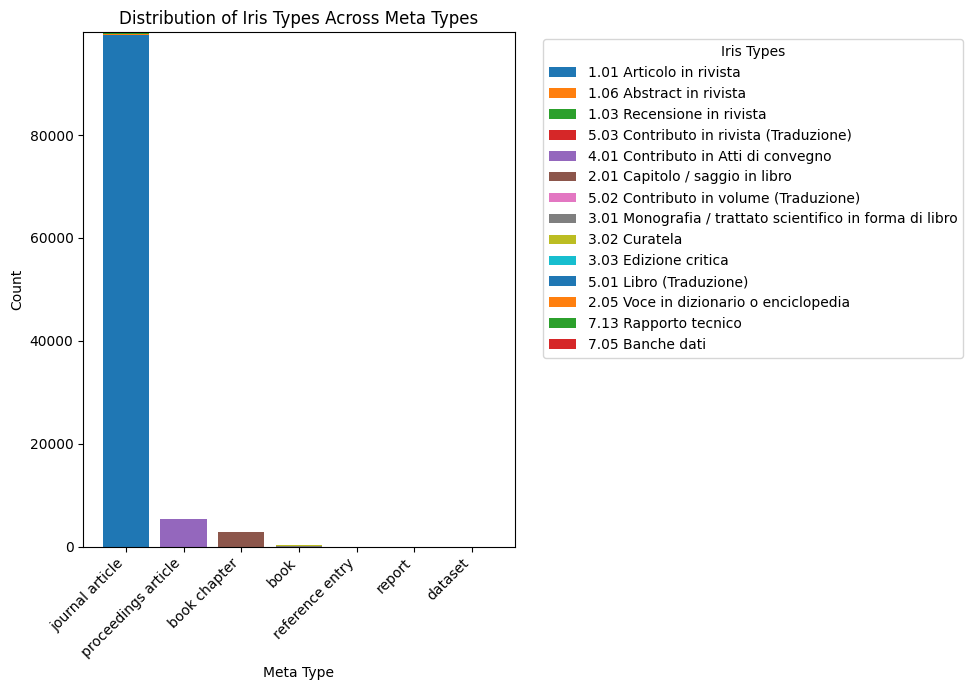

In [132]:
import matplotlib.pyplot as plt
import numpy as np

viz_df = (
    viz_df
    .explode("iris_types")
    .with_columns([
        pl.col("iris_types").struct.field("iris_type").alias("iris_type"),
        pl.col("iris_types").struct.field("iris_count").alias("iris_count")
    ])
    .drop("iris_types")
)
viz_df_pivot = viz_df.pivot(values="iris_count", index="meta_type", on="iris_type")


df_pivot = viz_df_pivot.fill_null(0)

meta_types = df_pivot['meta_type'].to_list()
iris_types = df_pivot.columns[1:]  # All columns except 'meta_type'

bar_data = np.array([df_pivot[col].to_list() for col in iris_types])
fig, ax = plt.subplots(figsize=(10, 7))
bottom = np.zeros(len(meta_types))

for i, iris_type in enumerate(iris_types):
    ax.bar(meta_types, bar_data[i], bottom=bottom, label=iris_type)
    bottom += bar_data[i]

ax.set_title("Distribution of Iris Types Across Meta Types")
ax.set_xlabel("Meta Type")
ax.set_ylabel("Count")
ax.legend(title="Iris Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

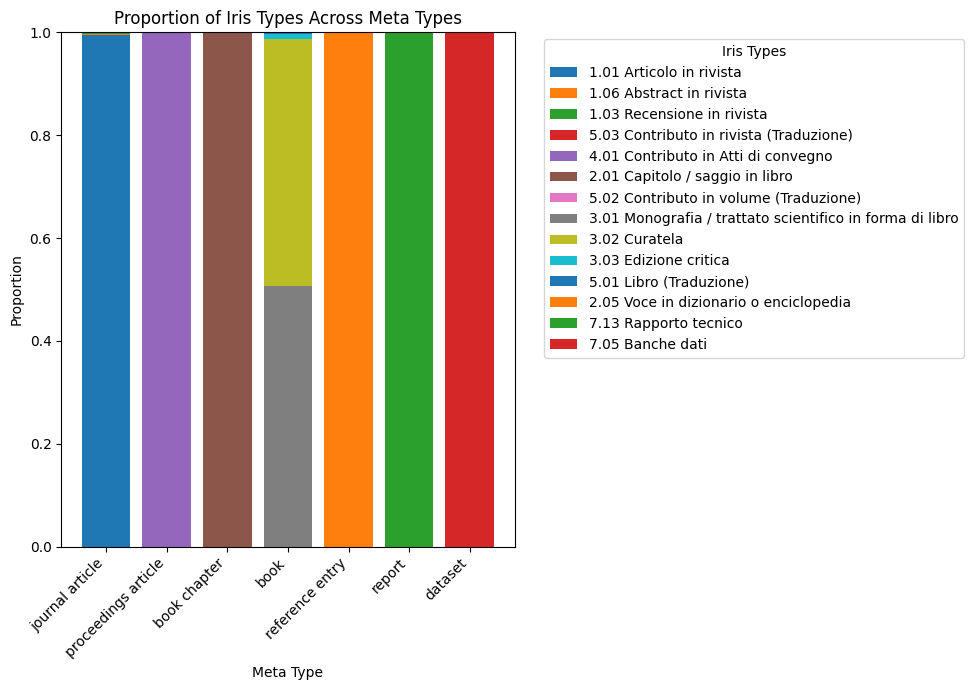

In [133]:
bar_data_normalized = bar_data / bar_data.sum(axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
bottom = np.zeros(len(meta_types))

for i, iris_type in enumerate(iris_types):
    ax.bar(meta_types, bar_data_normalized[i], bottom=bottom, label=iris_type)
    bottom += bar_data_normalized[i]

ax.set_title("Proportion of Iris Types Across Meta Types")
ax.set_xlabel("Meta Type")
ax.set_ylabel("Proportion")
ax.legend(title="Iris Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

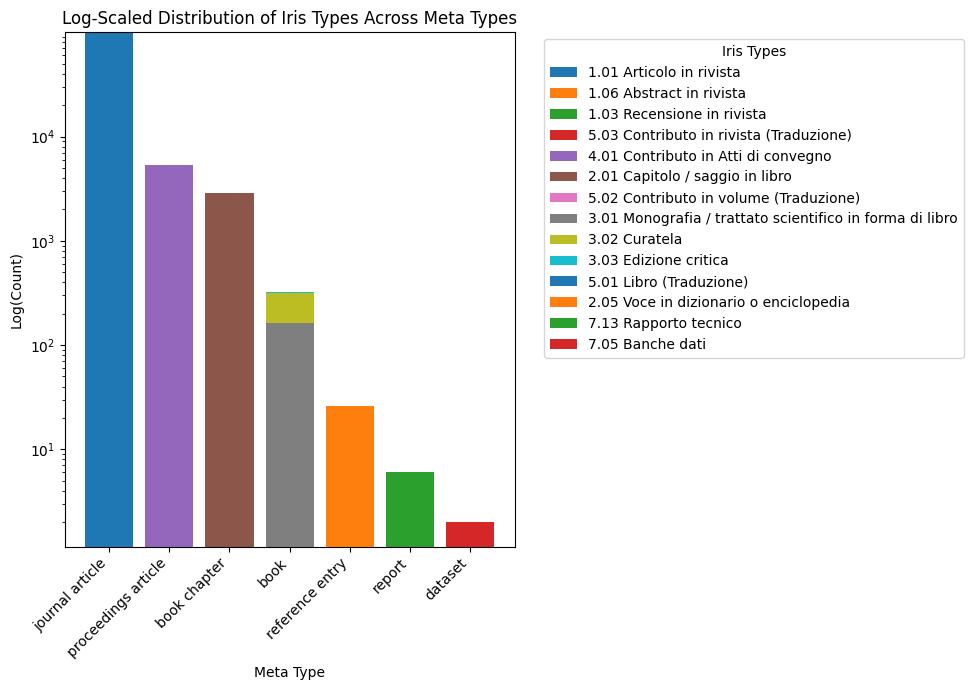

In [134]:
fig, ax = plt.subplots(figsize=(10, 7))
bottom = np.zeros(len(meta_types))

for i, iris_type in enumerate(iris_types):
    ax.bar(meta_types, bar_data[i], bottom=bottom, label=iris_type)
    bottom += bar_data[i]

ax.set_yscale('log')
ax.set_title("Log-Scaled Distribution of Iris Types Across Meta Types")
ax.set_xlabel("Meta Type")
ax.set_ylabel("Log(Count)")
ax.legend(title="Iris Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

In [82]:
print(not_matching_type.select(pl.len()).collect(streaming=True).item(), 'elements with non-matching type')

6514 elements with non-matching type


In [137]:
(
    not_matching_type
    .select(pl.col('meta_type').value_counts(sort=True))
.collect(streaming=True)
)

shape: (16, 1)
┌─────────────────────────────┐
│ meta_type                   │
│ ---                         │
│ struct[2]                   │
╞═════════════════════════════╡
│ {"journal article",2766}    │
│ {"book chapter",1566}       │
│ {"",1385}                   │
│ {"book",406}                │
│ {"proceedings article",229} │
│ {"proceedings",51}          │
│ {"web content",39}          │
│ {"report",20}               │
│ {"reference entry",16}      │
│ {"reference book",15}       │
│ {"journal",12}              │
│ {"dataset",4}               │
│ {"dissertation",2}          │
│ {"computer program",1}      │
│ {"book series",1}           │
│ {"series",1}                │
└─────────────────────────────┘

In [155]:
viz_df = (
    not_matching_type
    .group_by('meta_type')
    .agg([
        pl.len().alias('count'),
        pl.col('iris_type').value_counts(sort=True).alias('iris_types').struct.rename_fields(['iris_type', 'iris_count'])
    ])
).sort('count', descending=True).collect(streaming=True).with_columns(
    pl.col('meta_type').replace('', 'No type')
)
viz_df

shape: (16, 3)
┌─────────────────────┬───────┬────────────────────────────────────────────────────────────────────┐
│ meta_type           ┆ count ┆ iris_types                                                         │
│ ---                 ┆ ---   ┆ ---                                                                │
│ str                 ┆ u32   ┆ list[struct[2]]                                                    │
╞═════════════════════╪═══════╪════════════════════════════════════════════════════════════════════╡
│ journal article     ┆ 2766  ┆ [{"1.04 Replica / breve intervento (e simili)",1427}, {"4.01       │
│                     ┆       ┆ Contributo in Atti di convegno",1029}, …                           │
│ book chapter        ┆ 1566  ┆ [{"4.01 Contributo in Atti di convegno",1389}, {"2.05 Voce in      │
│                     ┆       ┆ dizionario o enciclopedia",77}, … {"3.…                            │
│ No type             ┆ 1385  ┆ [{"1.01 Articolo in rivista",895}, {"2.01 Capitolo / saggio in     │
│                     ┆       ┆ libro",177}, … {"3.07 Bibliografia",1…                             │
│ book                ┆ 406   ┆ [{"2.01 Capitolo / saggio in libro",303}, {"4.01 Contributo in     │
│                     ┆       ┆ Atti di convegno",66}, … {"2.03 Postf…                             │
│ proceedings article ┆ 229   ┆ [{"2.01 Capitolo / saggio in libro",98}, {"1.01 Articolo in        │
│                     ┆       ┆ rivista",58}, … {"3.02 Curatela",1}]                               │
│ proceedings         ┆ 51    ┆ [{"4.01 Contributo in Atti di convegno",46}, {"4.02 Riassunto      │
│                     ┆       ┆ (Abstract)",2}, … {"3.01 Monografia / …                            │
│ web content         ┆ 39    ┆ [{"1.01 Articolo in rivista",35}, {"4.02 Riassunto (Abstract)",2}, │
│                     ┆       ┆ … {"1.04 Replica / breve interven…                                 │
│ report              ┆ 20    ┆ [{"4.01 Contributo in Atti di convegno",11}, {"1.01 Articolo in    │
│                     ┆       ┆ rivista",4}, … {"2.01 Capitolo / sag…                              │
│ reference entry     ┆ 16    ┆ [{"2.01 Capitolo / saggio in libro",12}, {"1.01 Articolo in        │
│                     ┆       ┆ rivista",4}]                                                       │
│ reference book      ┆ 15    ┆ [{"2.01 Capitolo / saggio in libro",11}, {"2.05 Voce in dizionario │
│                     ┆       ┆ o enciclopedia",4}]                                                │
│ journal             ┆ 12    ┆ [{"1.01 Articolo in rivista",10}, {"4.01 Contributo in Atti di     │
│                     ┆       ┆ convegno",1}, {"4.02 Riassunto (Abstr…                             │
│ dataset             ┆ 4     ┆ [{"1.01 Articolo in rivista",2}, {"4.01 Contributo in Atti di      │
│                     ┆       ┆ convegno",1}, {"3.02 Curatela",1}]                                 │
│ dissertation        ┆ 2     ┆ [{"7.13 Rapporto tecnico",1}, {"3.01 Monografia / trattato         │
│                     ┆       ┆ scientifico in forma di libro",1}]                                 │
│ computer program    ┆ 1     ┆ [{"7.05 Banche dati",1}]                                           │
│ book series         ┆ 1     ┆ [{"2.01 Capitolo / saggio in libro",1}]                            │
│ series              ┆ 1     ┆ [{"1.01 Articolo in rivista",1}]                                   │
└─────────────────────┴───────┴────────────────────────────────────────────────────────────────────┘

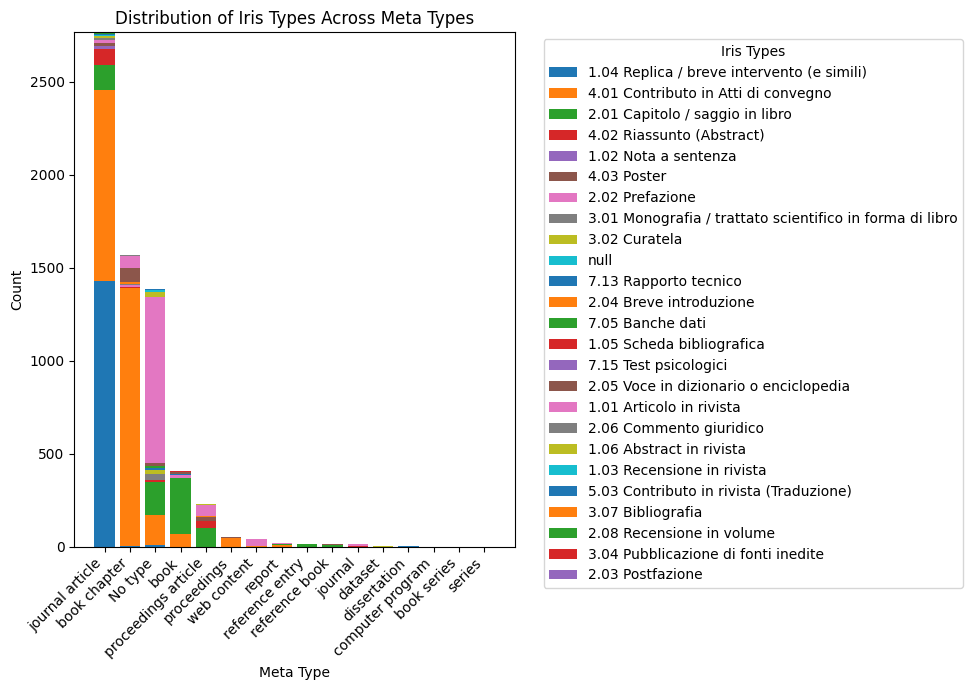

In [156]:
import matplotlib.pyplot as plt
import numpy as np

viz_df = (
    viz_df
    .explode("iris_types")
    .with_columns([
        pl.col("iris_types").struct.field("iris_type").alias("iris_type"),
        pl.col("iris_types").struct.field("iris_count").alias("iris_count")
    ])
    .drop("iris_types")
)
viz_df_pivot = viz_df.pivot(values="iris_count", index="meta_type", on="iris_type")


df_pivot = viz_df_pivot.fill_null(0)

meta_types = df_pivot['meta_type'].to_list()
meta_types = [el if el != '' else 'No type' for el in meta_types]
iris_types = df_pivot.columns[1:]  # All columns except 'meta_type'

bar_data = np.array([df_pivot[col].to_list() for col in iris_types])
fig, ax = plt.subplots(figsize=(10, 7))
bottom = np.zeros(len(meta_types))

for i, iris_type in enumerate(iris_types):
    ax.bar(meta_types, bar_data[i], bottom=bottom, label=iris_type)
    bottom += bar_data[i]

ax.set_title("Distribution of Iris Types Across Meta Types")
ax.set_xlabel("Meta Type")
ax.set_ylabel("Count")
ax.legend(title="Iris Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


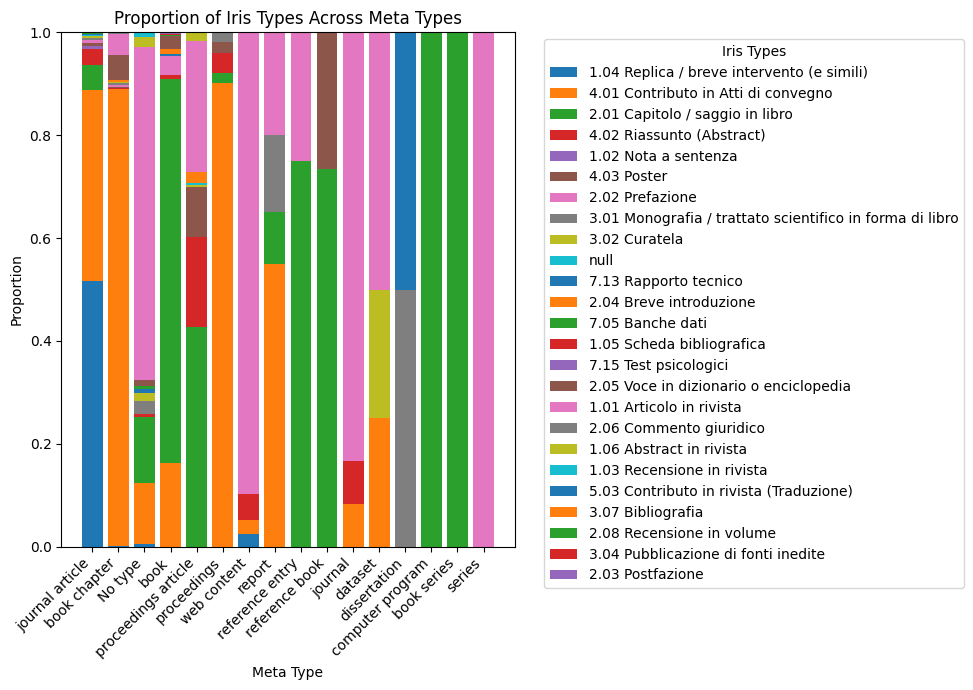

In [157]:
bar_data_normalized = bar_data / bar_data.sum(axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
bottom = np.zeros(len(meta_types))

for i, iris_type in enumerate(iris_types):
    ax.bar(meta_types, bar_data_normalized[i], bottom=bottom, label=iris_type)
    bottom += bar_data_normalized[i]

ax.set_title("Proportion of Iris Types Across Meta Types")
ax.set_xlabel("Meta Type")
ax.set_ylabel("Proportion")
ax.legend(title="Iris Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

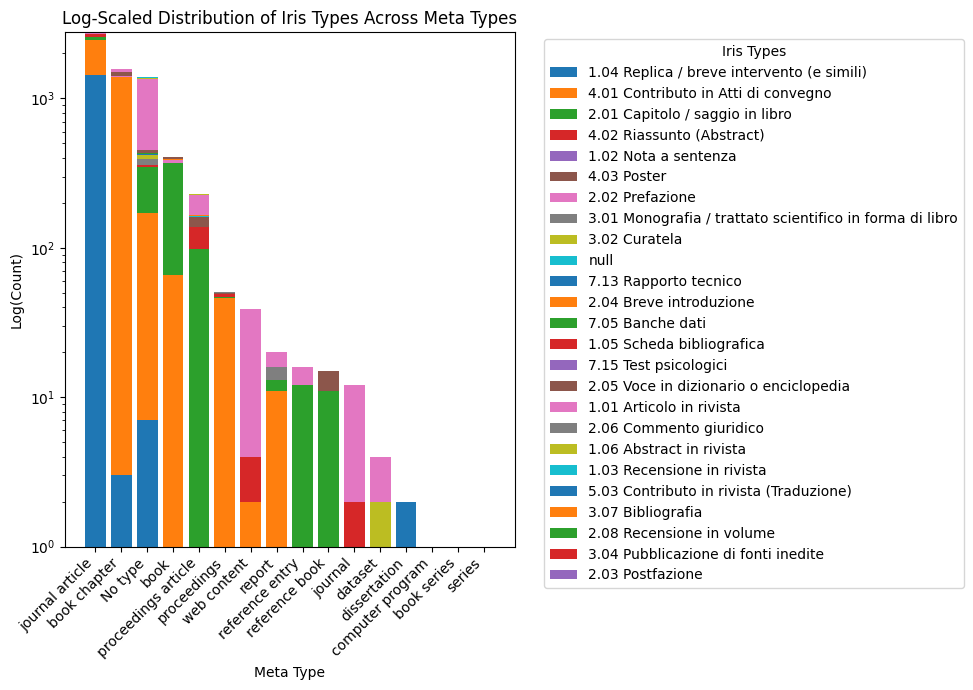

In [158]:
fig, ax = plt.subplots(figsize=(10, 7))
bottom = np.zeros(len(meta_types))

for i, iris_type in enumerate(iris_types):
    ax.bar(meta_types, bar_data[i], bottom=bottom, label=iris_type)
    bottom += bar_data[i]

ax.set_yscale('log')
ax.set_title("Log-Scaled Distribution of Iris Types Across Meta Types")
ax.set_xlabel("Meta Type")
ax.set_ylabel("Log(Count)")
ax.legend(title="Iris Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


---

# Index to Parquet

In [55]:
lf_iim = pl.scan_parquet('../data/iris_in_meta/iris_in_meta.parquet')

omids_list = (
    lf_iim
    .select('omid')
    .collect(streaming=True)
)['omid'].to_list()

len(omids_list)

115083

In [26]:
index_path = Path('../data/24356626')
#index_path = Path('/run/media/leo/0EAE24EE1463E70C/opencitations/index_dump/24356626')
output_dir = Path("../pp_data/iris_in_index")

In [ ]:
file_names = [Path(index_path) / Path(archive) for archive in os.listdir(index_path)]

for archive in tqdm(file_names):
    zip_file = ZipFile(archive)

    csvs = ['zip://'+n for n in zip_file.namelist() if n.endswith('.csv')]

    ddf = dd.read_csv(csvs, storage_options={'fo': zip_file.filename}, usecols=['id', 'citing', 'cited'])
    ddf = ddf[ddf['cited'].isin(omids_list) | ddf['citing'].isin(omids_list)]
    ddf.to_parquet(output_dir / archive.stem, write_index=False)

# RQ 3. What is the amount of citations (according to OpenCitations Index) included in the IRIS publications that are involved in OpenCitations Meta (as citing entity and as cited entity)?

In [4]:
iii_path = Path('../data/iris_in_index/')

iii_glob = glob.glob(str(iii_path / '*' / '*.parquet'))

In [5]:
lf_iii = pl.scan_parquet('../data/iris_in_index/iris_in_index.parquet')
rq3 = lf_iii.select(pl.len()).collect()
rq3 # old: 7890642

shape: (1, 1)
┌─────────┐
│ len     │
│ ---     │
│ u32     │
╞═════════╡
│ 7723941 │
└─────────┘

In [6]:
lf_iii.head().collect()

shape: (5, 3)
┌─────────────────────────────┬─────────────────────┬─────────────────────┐
│ id                          ┆ citing              ┆ cited               │
│ ---                         ┆ ---                 ┆ ---                 │
│ str                         ┆ str                 ┆ str                 │
╞═════════════════════════════╪═════════════════════╪═════════════════════╡
│ oci:06101850106-06201834752 ┆ omid:br/06101850106 ┆ omid:br/06201834752 │
│ oci:06101850106-06201834594 ┆ omid:br/06101850106 ┆ omid:br/06201834594 │
│ oci:06101850106-06301833659 ┆ omid:br/06101850106 ┆ omid:br/06301833659 │
│ oci:06101850106-06301833261 ┆ omid:br/06101850106 ┆ omid:br/06301833261 │
│ oci:06101850101-06301833742 ┆ omid:br/06101850101 ┆ omid:br/06301833742 │
└─────────────────────────────┴─────────────────────┴─────────────────────┘

In [228]:
#rq4
rq4a = (
    lf_iii
    .select('citing')
    .filter(
        ~pl.col('citing').is_in(omids_list)
    )
    .select(pl.len())
    .collect(streaming=True)
).item()

rq4b = (
    lf_iii
    .select('cited')
    .filter(
        ~pl.col('cited').is_in(omids_list)
    )
    .select(pl.len())
    .collect(streaming=True)
).item()


rq4 = pl.DataFrame({'citing': [rq4a], 'cited': [rq4b]})
rq4

# old: 
#3569644	3961725

shape: (1, 2)
┌─────────┬─────────┐
│ citing  ┆ cited   │
│ ---     ┆ ---     │
│ i64     ┆ i64     │
╞═════════╪═════════╡
│ 3433845 ┆ 3936674 │
└─────────┴─────────┘

In [229]:
rq5 = (
    lf_iii
    .select('citing', 'cited')
    .filter(
        pl.col('citing').is_in(omids_list) & pl.col(
            'cited').is_in(omids_list)
    )
    .select(pl.len())
    .collect()
)

rq5

# old: 359273

shape: (1, 1)
┌────────┐
│ len    │
│ ---    │
│ u32    │
╞════════╡
│ 353422 │
└────────┘

## RQ 4. How many of these citations come from and go to publications that are not included in IRIS?

## RQ 5. How many of these citations involve publications in IRIS as both citing and cited entities?

### Iris No ID analysis

In [5]:
inoid = pl.scan_parquet('../data/iris_no_id/iris_no_id.parquet')

inoid.head().collect()

shape: (5, 12)
┌─────────┬─────────┬──────────┬──────────┬───┬────────────────┬───────────┬─────────────┬─────────┐
│ ITEM_ID ┆ IDE_DOI ┆ IDE_ISBN ┆ IDE_PMID ┆ … ┆ PUB_NAME       ┆ PUB_PLACE ┆ PUB_COUNTRY ┆ LAN_ISO │
│ ---     ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---            ┆ ---       ┆ ---         ┆ ---     │
│ i64     ┆ str     ┆ str      ┆ str      ┆   ┆ str            ┆ str       ┆ str         ┆ str     │
╞═════════╪═════════╪══════════╪══════════╪═══╪════════════════╪═══════════╪═════════════╪═════════╡
│ 4837    ┆ null    ┆ null     ┆ null     ┆ … ┆ Karger         ┆ Basel     ┆ CHE         ┆ eng     │
│ 5279    ┆ null    ┆ null     ┆ null     ┆ … ┆ null           ┆ null      ┆ null        ┆ eng     │
│ 6196    ┆ null    ┆ null     ┆ null     ┆ … ┆ null           ┆ null      ┆ null        ┆ ita     │
│ 5444    ┆ null    ┆ null     ┆ null     ┆ … ┆ null           ┆ null      ┆ null        ┆ eng     │
│ 6457    ┆ null    ┆ null     ┆ null     ┆ … ┆ Dipartimento   ┆ Bologna   ┆ ITA         ┆ eng     │
│         ┆         ┆          ┆          ┆   ┆ di Scienze     ┆           ┆             ┆         │
│         ┆         ┆          ┆          ┆   ┆ Economiche,    ┆           ┆             ┆         │
│         ┆         ┆          ┆          ┆   ┆ Universita di  ┆           ┆             ┆         │
│         ┆         ┆          ┆          ┆   ┆ Bologna        ┆           ┆             ┆         │
└─────────┴─────────┴──────────┴──────────┴───┴────────────────┴───────────┴─────────────┴─────────┘

In [6]:
inoid.select(pl.len()).collect()

shape: (1, 1)
┌────────┐
│ len    │
│ ---    │
│ u32    │
╞════════╡
│ 103481 │
└────────┘

In [12]:
inoid.group_by('OWNING_COLLECTION_DES').agg(pl.len()).sort('len', descending=True).collect()  

shape: (50, 2)
┌──────────────────────────────────────────────────────────────────────────────┬───────┐
│ OWNING_COLLECTION_DES                                                        ┆ len   │
│ ---                                                                          ┆ ---   │
│ str                                                                          ┆ u32   │
╞══════════════════════════════════════════════════════════════════════════════╪═══════╡
│ 1.01 Articolo in rivista                                                     ┆ 37670 │
│ 4.02 Riassunto (Abstract)                                                    ┆ 16356 │
│ 4.01 Contributo in Atti di convegno                                          ┆ 13267 │
│ 2.01 Capitolo / saggio in libro                                              ┆ 6666  │
│ 1.03 Recensione in rivista                                                   ┆ 5343  │
│ …                                                                            ┆ …     │
│ 3.08 Edizione annotata/scolastica                                            ┆ 4     │
│ 3.05 Concordanze                                                             ┆ 3     │
│ 7.06 Prodotto artistico e spettacolare: Composizione musicale                ┆ 3     │
│ 7.11 Prodotto artistico e spettacolare: Prototipo d'arte e relativi progetti ┆ 3     │
│ null                                                                         ┆ 1     │
└──────────────────────────────────────────────────────────────────────────────┴───────┘

### Iris Not in Meta analysis

In [13]:
inim = pl.scan_parquet('../data/iris_not_in_meta/iris_not_in_meta.parquet')

inim.head().collect()

shape: (5, 3)
┌─────────┬───────────┬────────────────────────────────────────┐
│ iris_id ┆ iris_type ┆ id                                     │
│ ---     ┆ ---       ┆ ---                                    │
│ i64     ┆ i64       ┆ str                                    │
╞═════════╪═══════════╪════════════════════════════════════════╡
│ 8174    ┆ 59        ┆ doi:10.1016/j.pan.2014.05.397          │
│ 53696   ┆ 35        ┆ doi:10.1016/j.brainresbull.2003.12.006 │
│ 70550   ┆ 35        ┆ doi:10.14601/phytopathol_mediterr-1795 │
│ 75063   ┆ 35        ┆ doi:10.1002/ajmb.b.30111               │
│ 71723   ┆ 35        ┆ doi:10.1177/19714009050180s202         │
└─────────┴───────────┴────────────────────────────────────────┘

In [14]:
inim.select(pl.len()).collect()

shape: (1, 1)
┌───────┐
│ len   │
│ ---   │
│ u32   │
╞═══════╡
│ 54604 │
└───────┘

In [24]:
inim.group_by('iris_type').agg(pl.len()).sort('len', descending=True).collect().with_columns(pl.col('iris_type').replace_strict(type_dict))

shape: (40, 2)
┌──────────────────────────────────────────────────────────┬───────┐
│ iris_type                                                ┆ len   │
│ ---                                                      ┆ ---   │
│ str                                                      ┆ u32   │
╞══════════════════════════════════════════════════════════╪═══════╡
│ 2.01 Capitolo / saggio in libro                          ┆ 19102 │
│ 1.01 Articolo in rivista                                 ┆ 11009 │
│ 4.01 Contributo in Atti di convegno                      ┆ 8647  │
│ 3.01 Monografia / trattato scientifico in forma di libro ┆ 6372  │
│ 3.02 Curatela                                            ┆ 2692  │
│ …                                                        ┆ …     │
│ 7.01 Carta tematica e geografica                         ┆ 2     │
│ 3.05 Concordanze                                         ┆ 2     │
│ 7.10 Prodotto artistico e spettacolare: Manufatto        ┆ 2     │
│ 7.02 Carta geologica                                     ┆ 1     │
│ 7.04 Software                                            ┆ 1     │
└──────────────────────────────────────────────────────────┴───────┘